# Import Library & Set Globals

In [18]:
%load_ext jupyter_black

# base
import os
import sys
import warnings
import logging

logging.basicConfig(level="INFO")
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import pickle
import pandas as pd
import itables

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

itables.init_notebook_mode(connected=True)  # Use connected=False for offline use
warnings.simplefilter("ignore", pd.errors.DtypeWarning)
warnings.simplefilter("ignore", pd.errors.PerformanceWarning)
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.WARNING)

# single cell
import scanpy as sc
import decoupler as dc
import gseapy as gp

# custom
sys.path.append("../..")
from python import *

import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

converter = get_converter()

# R_preload()
%load_ext rpy2.ipython

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%matplotlib inline
study = "paper_processed_FULL"

CORES = 10
DATADIR = "../../../data"
REFDIR = "../../../references"
DOUBLETMETHODS = ["scDblFinder", "DoubletFinder", "doubletdetection", "scrublet"]

# Access adata

In [4]:
study = "paper_processed"

# experiment = os.path.join('cellbender',study)
# filename = "output_filtered"
# filetype = ".h5"
# data_dir = DATADIR

experiment_dir = os.path.join('cellranger',study)
filename = "1/outs/raw_feature_bc_matrix"
filetype = ".mtx"
data_dir = DATADIR
convertR = False

adatas = GetSingleCellData(data_dir, experiment_dir, filename, filetype, convertR)

for ad in adatas:
    ad.obs['Groups'] = ad.obs['Identifier']
    ad.obs['Experiment'], ad.obs['Condition'], ad.obs['Sample Type'] = np.array(ad.obs['Identifier'].str.split('-|_').to_list()).T

## Data Structures

#### SingleCellExperiment object (in R) is presented below
![SingleCellExperiment Object (in R)](https://hbctraining.github.io/scRNA-seq/img/sce_description.png)

#### AnnData object (in Python) is similar!
* **Assay** data is stored in `adata.X`
* **Feature Metadata** is stored in `adata.vars`
* **Cell Metadata** is stored in `adata.obs`
* **Dimensionality Reduction** (and other multicolumn data by cell) is stored in `adata.obsm`
* additional layers are stored in `adata.layers` & `adata.raw`

# Preprocessing

### QC

In [ ]:
adatas = [Filter_QC(dat, mt_perc=15, ribo_perc=15, verbose=True) for dat in adatas]
PlotQC = True

#### QC Plots

Plot QC Filters for 1 dataset

In [ ]:
if PlotQC:
    # sns.displot(adata[1].obs['total_counts'], bins=100, kde=False).figure
    tmp = adatas[0]
    sc.pl.violin(
        tmp,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True
    )
    sc.pl.scatter(tmp, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Plot QC Metrics for all datasets

In [ ]:
def QC_Plot(df, value, groupby):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    g = sns.FacetGrid(df, row=groupby, hue=groupby, aspect=15, height=0.5, palette="tab20")

    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, value)

    g.figure.subplots_adjust(hspace=-.6)

    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')

    return g.figure

if PlotQC:
    df = pd.concat([x.obs for x in adatas])
    groupby = 'Groups'
    df = df.sort_values(groupby)

    QC_Plot(df,"log1p_total_counts",groupby)
    QC_Plot(df,"pct_counts_mt",groupby)
    QC_Plot(df,"n_genes",groupby)
    QC_Plot(df,"pct_counts_in_top_20_genes",groupby)

### Doublets

In [ ]:
print("methods available:", DOUBLETMETHODS)
compare_doublets = True
method = 'scDblFinder'
method_short = 'scDF'

if compare_doublets is True:
    for method in DOUBLETMETHODS:
        adatas = [Filter_Doublet(dat,method,remove=False) for dat in adatas]

else:
    print(f"Doublet method selected: {method}\n")
    adatas = [Filter_Doublet(dat,method,remove=True) for dat in adatas]
    for dat in adatas:
        print(len(dat), dat.uns['doublets_removed'])
        
adatas

In [ ]:
# save
annotation = method_short

savedir = os.path.join(DATADIR,'processed', study, 'py', '1_preprocessed')
os.makedirs(savedir, exist_ok=True)
with open(os.path.join(savedir, f'{annotation}.pickle'), 'wb') as handle:
    pickle.dump(adatas, handle)

# Integration

### Pre-Doublet Integration

In [ ]:
# load adata
annotation = "hasDoublets"
with open(os.path.join(DATADIR,'processed',study,'py',
                                  '1_preprocessed', f'{annotation}.pickle'),
                                  'rb') as handle:
    adatas = pickle.load(handle)

In [ ]:
batch_column = 'Groups'
hvg_kind = 'seurat_v3'
int_kind = 'harmony'

# merge
adata = sc.concat(adatas, join='outer')
adata.raw = adata.copy()

# order categories
order_obs(ad, "Identifier", ['GSM7747185-LFD_eWAT','GSM7747187-HFD_eWAT','GSM7747186-LFD_iWAT','GSM7747188-HFD_iWAT'])
order_obs(ad, "Groups", ['GSM7747185-LFD_eWAT','GSM7747187-HFD_eWAT','GSM7747186-LFD_iWAT','GSM7747188-HFD_iWAT'])
order_obs(ad, "Experiment", ['GSM7747185', 'GSM7747186', 'GSM7747187', 'GSM7747188'])
order_obs(ad, "Condition", ['LFD', 'HFD'])
order_obs(ad, "Sample Type", ['eWAT', 'iWAT'])

# process & integrate
adata = Normalize(adata, kind='log1p', batch_column=batch_column)
adata = FindVariableGenes(adata, kind=hvg_kind, batch_column=batch_column)
adata = Integrate(adata, kind = int_kind, batch_column=batch_column, use_var_genes=False)
adata = Visualize(adata, key="_doublet")


In [ ]:
# save
annotation = "hasDoublets"
savedir = os.path.join(DATADIR,'processed',study,'py','2_integrated')
os.makedirs(savedir, exist_ok=True)
adata.write(os.path.join(savedir, f'{annotation}.h5ad'))

### Post-Doublet Integration

In [ ]:
# load data
annotation = "doublet_cleaned"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '1_preprocessed', f'{annotation}.h5ad'))
try:
    del adata.uns, adata.var, adata.obsm, adata.varm, adata.obsp, adata.layers["normalized"]
except:
    pass

In [ ]:
print(f"Doublets removed: {adata.obs["manual_doublet"].sum()}")
adata = adata[~adata.obs["manual_doublet"]]

f,ax = plt.subplots(1,1,figsize=(6,8),layout="constrained")
doublet_df = pd.DataFrame([adata.obs.groupby('leiden_doublets')[f'predicted_doublet-{method}'].mean().sort_values() for method in DOUBLETMETHODS]).T
doublet_df.columns = doublet_df.columns.str.replace('predicted_doublet-','', regex=True)
sns.heatmap(doublet_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

In [ ]:
batch_column = 'Groups'
hvg_kind = 'seurat_v3'
int_kind = 'harmony'

# process & integrate
adata = Normalize(adata, kind='log1p', batch_column=batch_column)
adata = FindVariableGenes(adata, kind=hvg_kind, batch_column=batch_column)
adata = Integrate(adata, kind = int_kind, batch_column=batch_column, use_var_genes=False)
adata = Visualize(adata)

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony"
savedir = os.path.join(DATADIR,'processed',study,'py','2_integrated')
os.makedirs(savedir, exist_ok=True)
adata.write(os.path.join(savedir, f'{annotation}.h5ad'))

### Plot

In [ ]:
annotation = "manDoublet-seuratV3-harmony"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '2_integrated', f'{annotation}.h5ad'))
key = ""

In [ ]:
# plot embeddings
f = plt.figure(figsize=(13,5), layout="constrained")
check_integration(adata, "Groups", f, embeddings=["X_umap"+key,"LocalMAP"+key], mini=True)
f = plt.figure(figsize=(18,12), layout="constrained")
check_integration(adata, "Groups", f, embeddings=["X_umap"+key,"LocalMAP"+key], nrow=2, ncol=2, mini=False)

In [ ]:
# Feature marker plots
markers = ["Adipoq", "Pdgfra", "Upk3b", "Cdh5", "Rgs5", "Adgre1", "Flt3", "Cpa3", "Skap1", "Igkc"]
sc.pl.embedding(adata, basis="X_umap"+key, color=markers, layer='normalized')
sc.pl.embedding(adata, basis="LocalMAP"+key, color=markers, layer='normalized')

# Clustering

### Pre-Doublet Cluster

In [ ]:
# load data
annotation = "hasDoublets"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '2_integrated', f'{annotation}.h5ad'))
# adata.obs["Groups"] = pd.Categorical(adata.obs["Groups"],categories=['LFD_eWAT', 'HFD_eWAT', 'LFD_iWAT', 'HFD_iWAT'], ordered=True)

In [ ]:
resolution = 1
runCluster = True

# leiden clustering
key = 'leiden_doublets'
if runCluster is True:
    sc.tl.leiden(adata, resolution,random_state=123, key_added=key)
    print(f"{len(adata.obs[key].unique())} clusters found at resolution {int(adata.uns[key]['params']['resolution'])}!")

# figure prept
cluster_c = color_gen(adata.obs[key])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1.5])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
for rs in axs[:]:
    for ax in rs[:]:
        ax.remove()

# Large LocalMAP plot
embedding = "X_umap" #"LocalMAP" #"X_umap"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata, basis=embedding, color=[key], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7, legend_loc="none")
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adipoq", "Pdgfra", "Upk3b", "Cdh5", "Rgs5", "Adgre1", "Flt3", "Cpa3", "Skap1", "Igkc"]
plot_violinplot(adata, markers, key, sf[1])

In [ ]:
checkDoublets(adata,'X_umap_doublet','leiden_doublets')

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden',layer="normalized", use_raw=False)
gene_groups = sc.get.rank_genes_groups_df(adata, group=None)

In [ ]:
doublet_clusters = pd.Series([11,15,16,23,21,26,14,28]).astype(str)
adata.obs["manual_doublet"] = adata.obs[key].isin(doublet_clusters)
sc.pl.embedding(adata, basis='LocalMAP', color = 'manual_doublet')

In [ ]:
# save
annotation = "doublet_cleaned"
savedir = os.path.join(DATADIR,'processed',study,'py','1_preprocessed')
os.makedirs(savedir, exist_ok=True)
adata.write(os.path.join(savedir, f'{annotation}.h5ad'))

### Cluster

In [ ]:
# load data
annotation = "manDoublet-seuratV3-harmony"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '2_integrated', f'{annotation}.h5ad'))
# adata.obs["Groups"] = pd.Categorical(adata.obs["Groups"],categories=['LFD_eWAT', 'HFD_eWAT', 'LFD_iWAT', 'HFD_iWAT'], ordered=True)

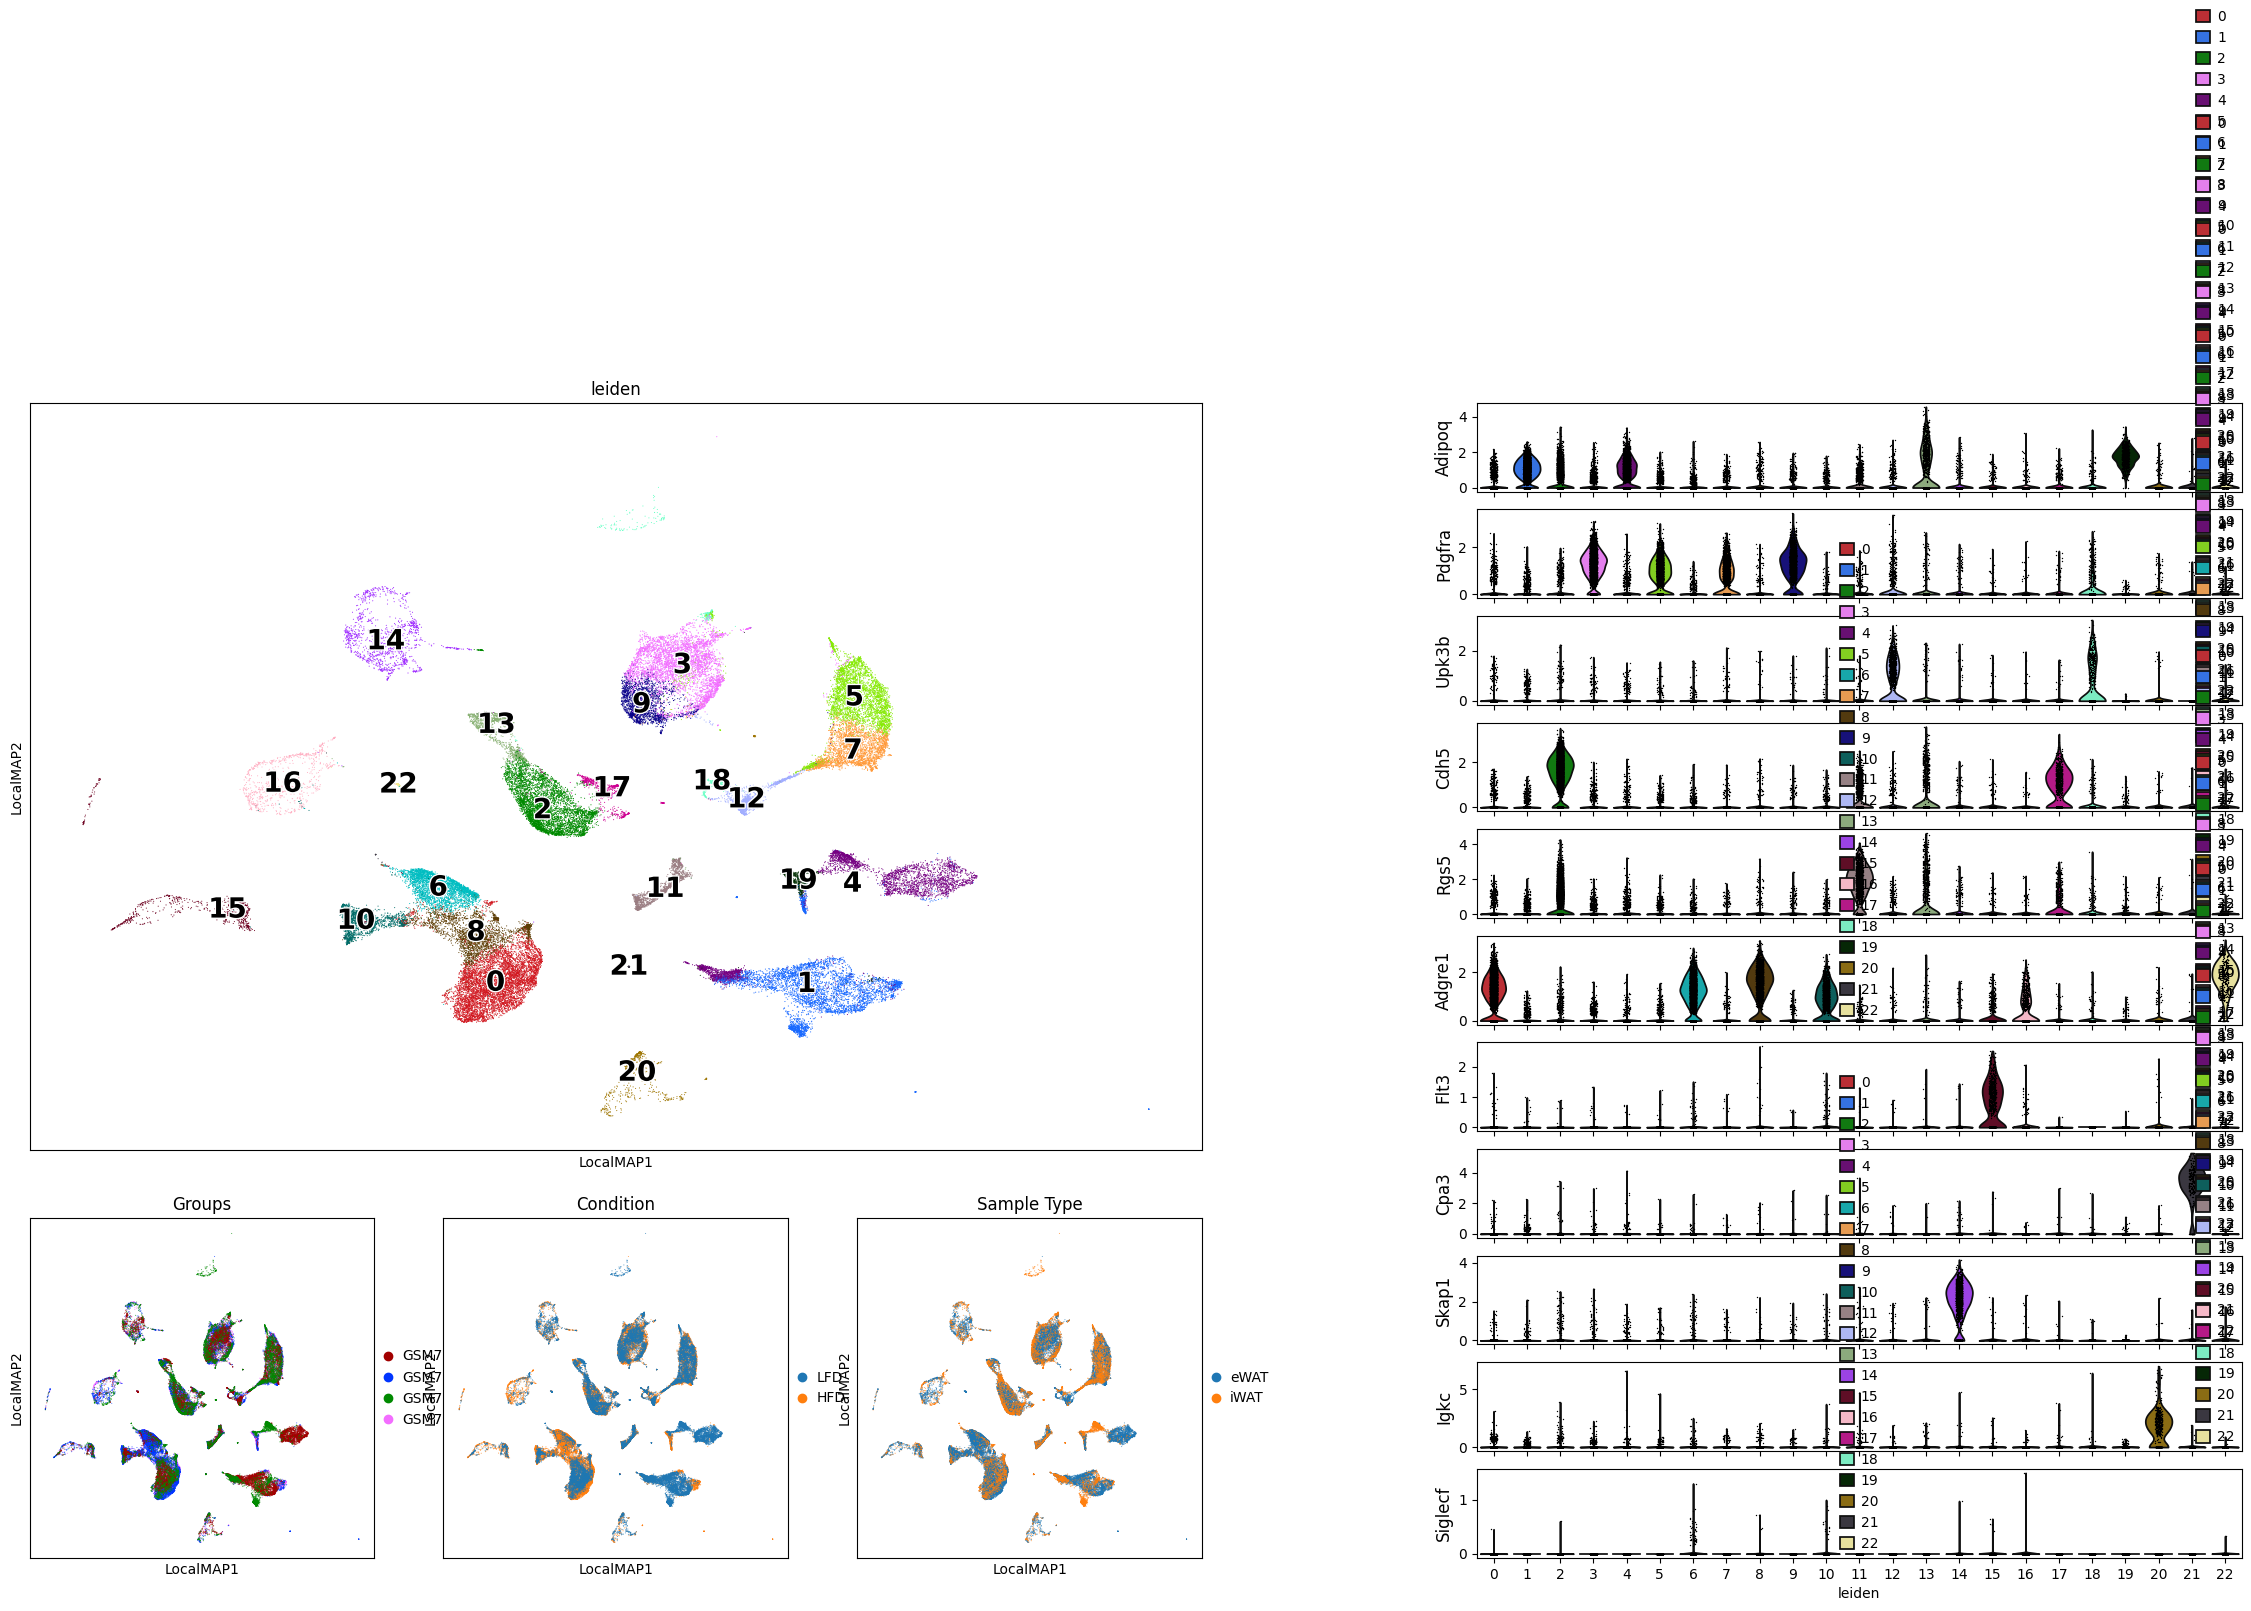

In [6]:
resolution = 1
runCluster = False

# leiden clustering
key = 'leiden'
if runCluster is True:
    sc.tl.leiden(adata, resolution,random_state=123, key_added=key)
    print(f"{len(adata.obs[key].unique())} clusters found at resolution {int(adata.uns[key]['params']['resolution'])}!")

# figure prep
cluster_c = color_gen(adata.obs[key])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2.3, 1.5])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "LocalMAP" #"X_umap"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata, basis=embedding, color=[key], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adipoq", "Pdgfra", "Upk3b", "Cdh5", "Rgs5", "Adgre1", "Flt3", "Cpa3", "Skap1", "Igkc", "Siglecf"]
plot_violinplot(adata, markers, key, sf[1])

In [ ]:
checkDoublets(adata,'X_umap','leiden')
adata = adata[~(adata.obs["leiden"] == "23")]

### Annotate

In [ ]:
remap = True
key = 'leiden'

if remap is True:
    mapping = {
        0  : 'Macrophage',      1  : 'Adipocyte',       2  : 'Endothelial',     3  : 'Fibroblast',      4  : 'Adipocyte',
        5  : 'Fibroblast',      6  : 'Macrophage',      7  : 'Fibroblast',      8  : 'Macrophage',      9  : 'Fibroblast',
        10 : 'Macrophage',      11 : 'PC/SMC',          12 : 'Mesothelial',     13 : 'Adipocyte',       14 : 'T Cell',
        15 : 'Dendritic Cell',  16 : 'Macrophage',      17 : 'Endothelial',     18 : 'Mesothelial',     19 : 'Adipocyte',
        20 : 'B Cell',          21 : 'Mast Cell',       22 : 'Macrophage'
    }

    try:
        assert len(mapping) == len(adata.obs[key].unique())
    except AssertionError:
        print(f"At resolution {resolution}, {len(adata.obs[key].unique())} clusters identified, but only {len(mapping)} mappings provided!")

    adata.obs['cell_type'] = adata.obs[key].astype(int).replace(mapping)
    adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'],
                                            categories=['Adipocyte', 'Fibroblast', 'Mesothelial', 'Endothelial', 'PC/SMC', 'Macrophage', 'Dendritic Cell', 'Mast Cell', 'T Cell', 'B Cell'],
                                            ordered=True)

for obsm in ["X_umap", "LocalMAP"]:
    f,axs = plt.subplots(1,3,figsize=(20,5),layout='constrained')
    sc.pl.embedding(adata, basis=obsm, color=[key], ax=axs[0], show=False, palette=color_gen(adata.obs["leiden"]).to_list())
    sc.pl.embedding(adata, basis=obsm, color = ['cell_type'], ax=axs[1], show=False, palette=color_gen(adata.obs['cell_type']).to_list())
    sc.pl.embedding(adata, basis=obsm, color = ['Groups'], ax=axs[2], show=False, palette=color_gen(adata.obs['Groups']).to_list(), alpha=0.5)

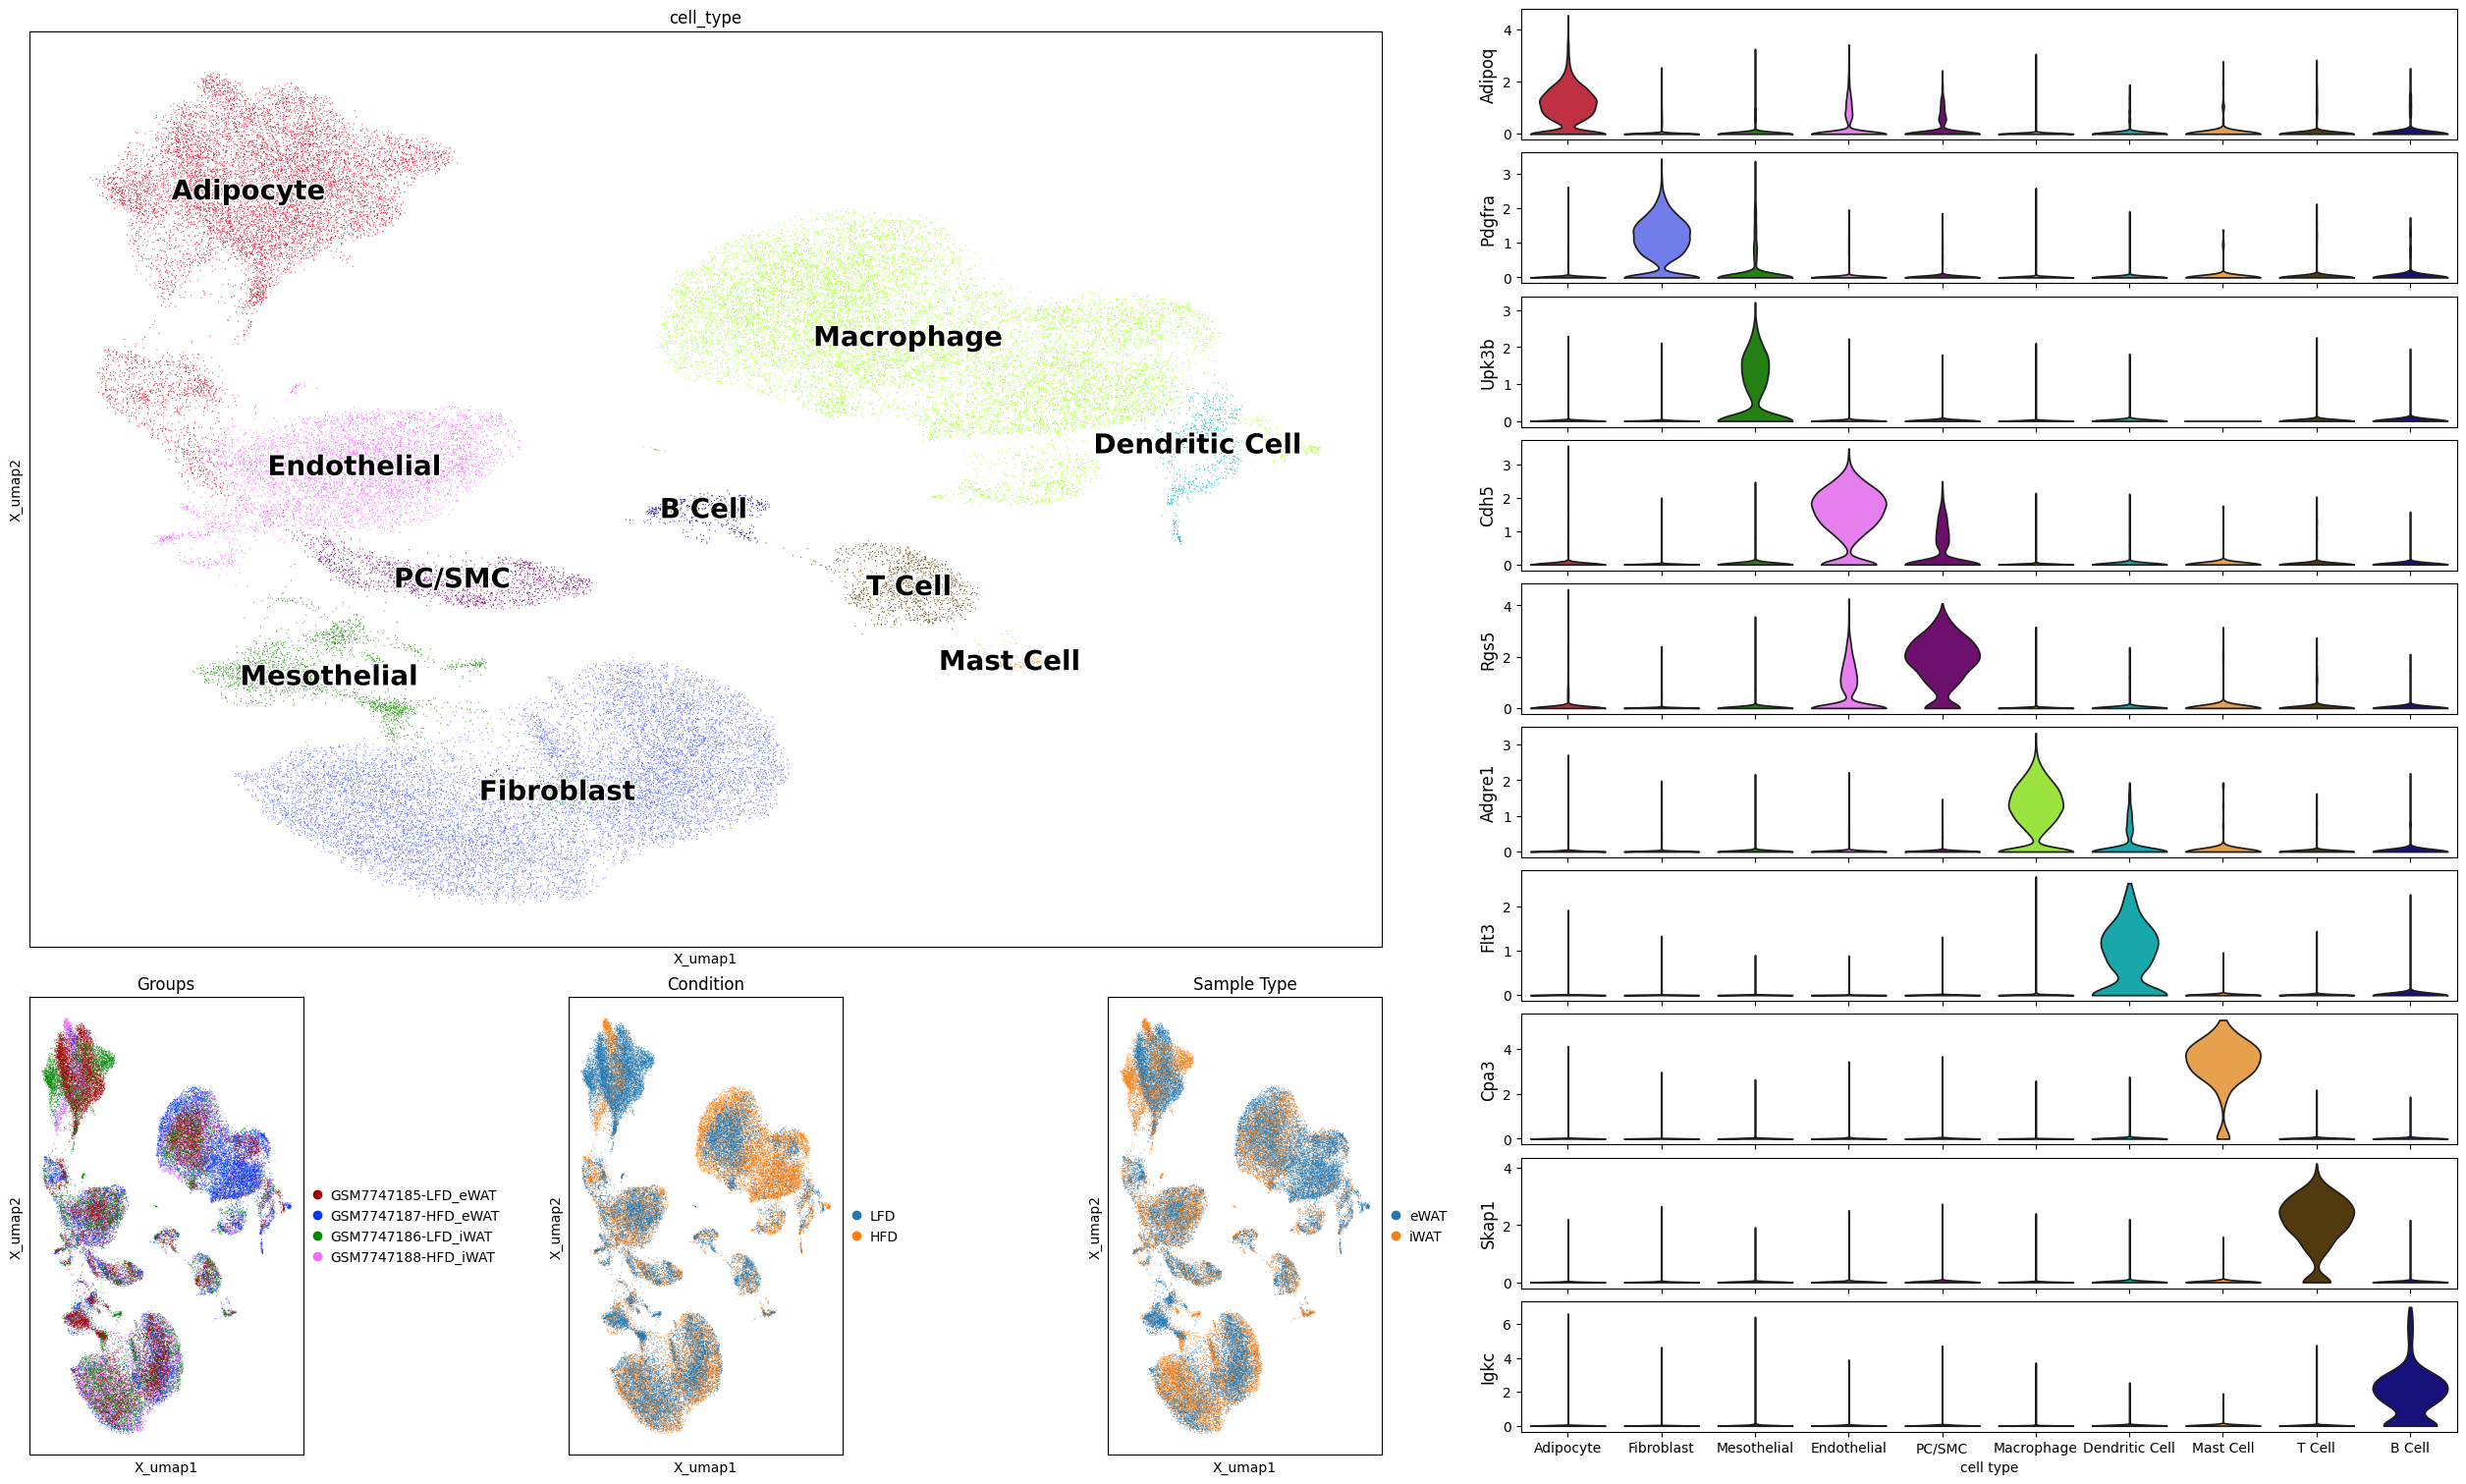

In [5]:
# figure prep
key = "cell_type"
cluster_c = color_gen(adata.obs[key])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2.2, 1.5])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "X_umap" # "LocalMAP" # "X_umap"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata, basis=embedding, color=[key], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adipoq", "Pdgfra", "Upk3b", "Cdh5", "Rgs5", "Adgre1", "Flt3", "Cpa3", "Skap1", "Igkc"]
plot_violinplot(adata, markers, key, sf[1], useStripPlot=False)

In [ ]:
f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata, "Groups", "cell_type", pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata, "Groups", "cell_type", pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata, "cell_type", "Groups", pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata, "cell_type", "Groups", pct=True, ax=axs[1])

#### PangloDB annotation

In [ ]:
# Get PangloDB
markers = dc.op.resource('PanglaoDB', organism='mouse')
# Filter by canonical_marker and human
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
# Cleaning
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers = markers.rename(columns={'cell_type': 'source', 'genesymbol': 'target'})
markers = markers[['source', 'target']]

# fit model
dc.mt.ulm(data=adata, net=markers, tmin=3)
score = dc.pp.get_obsm(adata, key='score_ulm')
score.layers['self'] = score.X.copy()

# get top cell types
df = dc.tl.rankby_group(adata=score, groupby='leiden', reference='rest', method='t-test_overestim_var')
df = df[df['stat'] > 0]
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['name'].apply(lambda x: list(x)).to_dict()

# Cell Types of Interest
cell_types = ['Adipocytes', 'Fibroblasts', 'Endothelial cells', 'Pericytes', 'Smooth muscle cells', 'Macrophages', 'Monocytes', 'Dendritic cells', 'T cells']

# Plotting
sc.pl.embedding(score, basis="LocalMAP", color=cell_types)
sc.pl.embedding(score, basis="LocalMAP", color='cell_type')

f = plt.figure(figsize=(6,15),layout="constrained")
plot_violinplot(score,cell_types,'leiden',f,'self')

### DEGs

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='cell_type',
                        use_raw=False, layer="normalized", key_added='de_all',
                        method='wilcoxon')

In [ ]:
f, ax = plt.subplots(1,1,figsize=(30,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="cell_type", key='de_all',
    standard_scale="var", n_genes=10,
    var_group_rotation=30, ax=ax
)

comparison = ["Adipocyte", "Fibroblast", "Macrophage"]
f, ax = plt.subplots(1,1,figsize=(30,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="cell_type", groups=comparison, key='de_all',
    standard_scale="var", n_genes=30,
    var_group_rotation=30, ax=ax
)

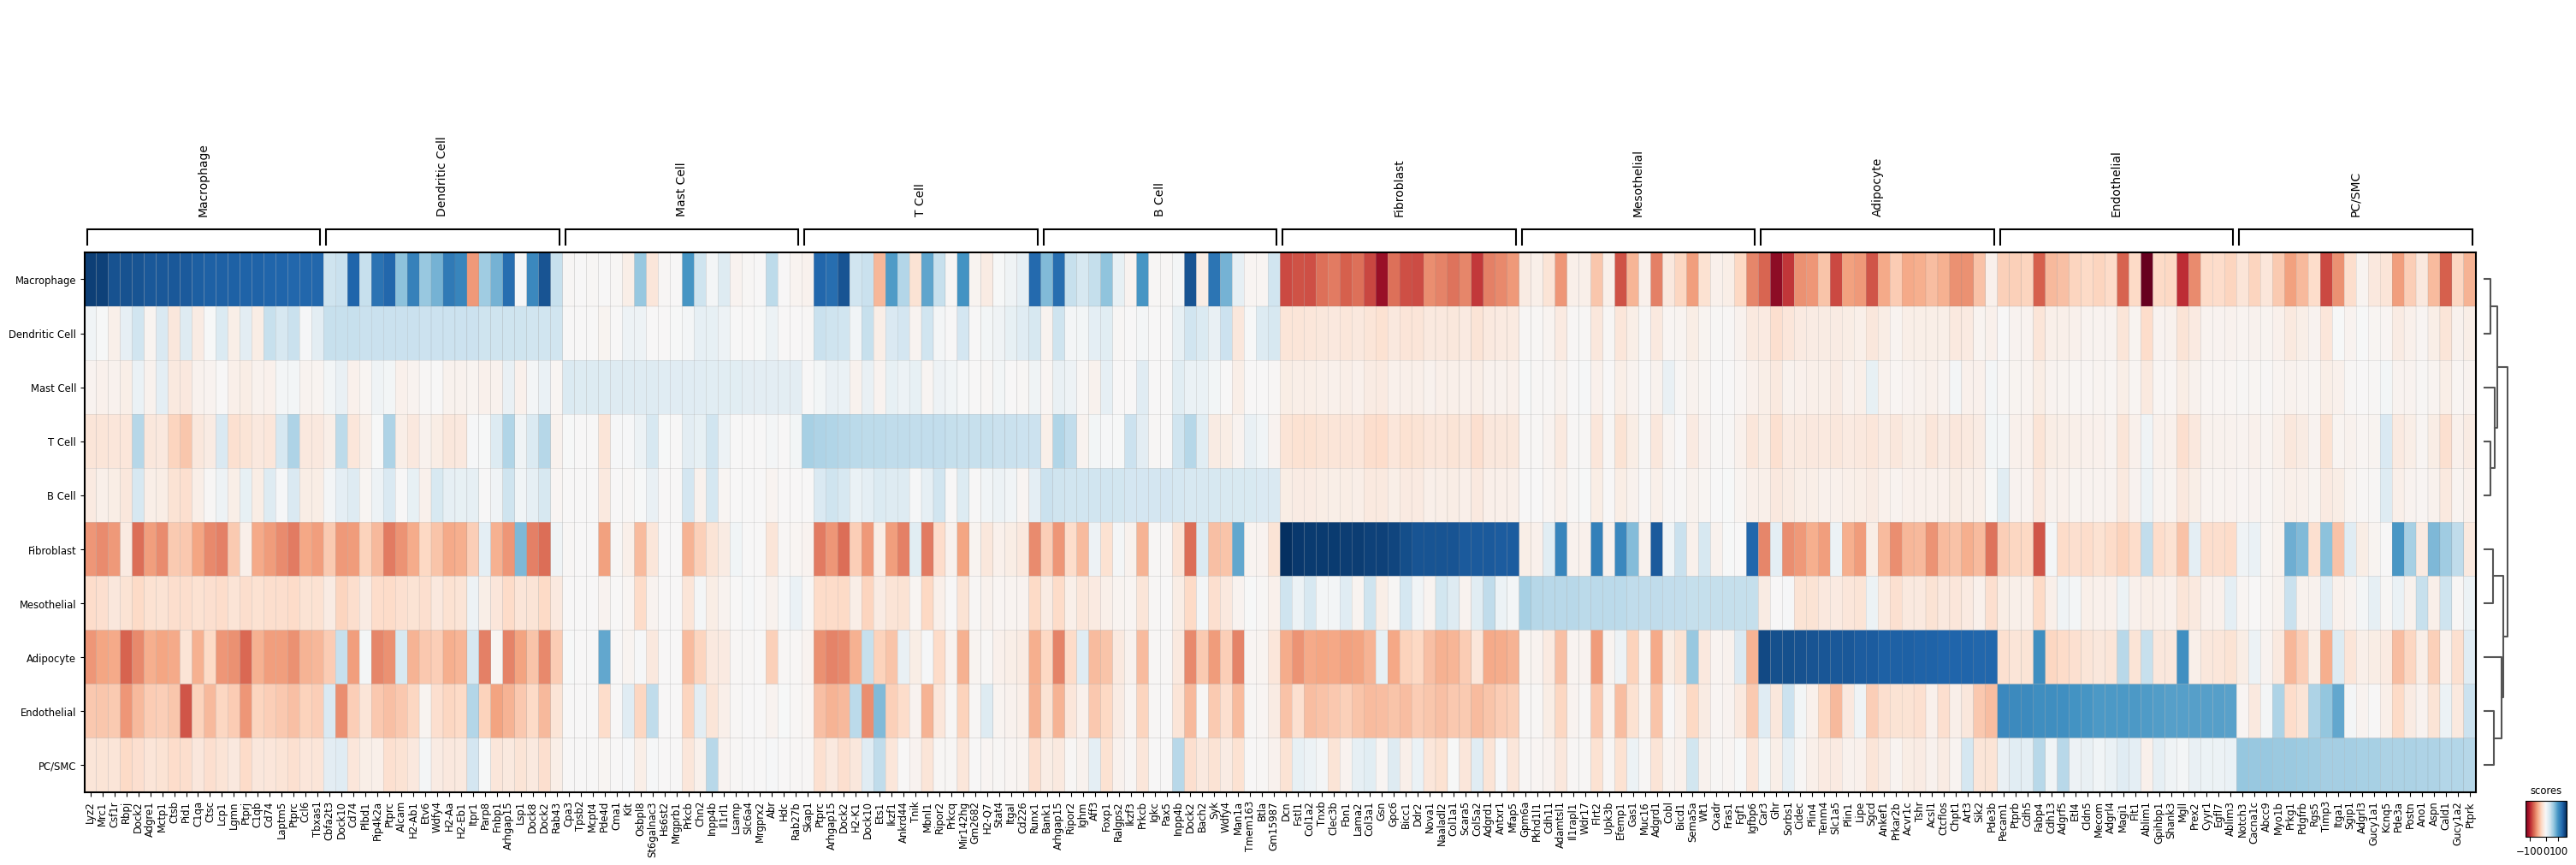

In [ ]:
f,ax = plt.subplots(1,1,figsize=(30,10), layout="constrained")
sc.pl.rank_genes_groups_matrixplot(
    adata, groups=None, groupby="cell_type", values_to_plot="scores",
    n_genes=20, key='de_all', layer="normalized", use_raw=False,
    ax=ax, cmap="RdBu", vcenter=0,
)

In [ ]:

df = sc.get.rank_genes_groups_df(adata, group=None, key='de_all')

marker_of_interest = "Adgre1"
df[df["names"] == marker_of_interest]

celltype_of_interest = "Adipocyte"
df[df["group"] == celltype_of_interest].head(50)

### Psuedobulk DEGs

see Decoupler PB https://decoupler.readthedocs.io/en/latest/notebooks/scell/rna_psbk.html#differential-expression-analysis
in-depth design matrix discussion: https://f1000research.com/articles/9-1444

In [ ]:
pdata = dc.pp.pseudobulk(
    adata,
    sample_col="Groups",
    groups_col="cell_type",
    # min_prop=0.1,
    # min_smpls=3,
    layer="counts",
    raw=False
)
pdata.layers["counts"] = pdata.X.copy()

# Does PC1 captures a meaningful biological or technical fact?
pdata.obs["lib_size"] = pdata.X.sum(1)

# Normalize
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

logFCs, pvals = dc.pp.contrast(
    pdata,
    group_col="cell_type",
    condition_col="condition",
    condition="stim",
    reference="ctrl",
    method="t-test",
)

### GSEA
* See https://www.gsea-msigdb.org/gsea/msigdb/mouse/genesets.jsp?collection=M8 for more MSigDB details

In [4]:
ref_dir = os.path.join(REFDIR, "interactome")
hallmark = dc.pp.read_gmt(os.path.join(ref_dir, "mh.all.v2025.1.Mm.symbols.gmt"))

tgfb_genes = hallmark[hallmark.source.isin(["HALLMARK_TGF_BETA_SIGNALING"])].target
tnfa_genes = hallmark[hallmark.source.isin(["HALLMARK_TNFA_SIGNALING_VIA_NFKB"])].target
il_genes = hallmark[
    hallmark.source.isin(
        ["HALLMARK_IL2_STAT5_SIGNALING", "HALLMARK_IL6_JAK_STAT3_SIGNALING"]
    )
].target
ifn_genes = hallmark[
    hallmark.source.isin(
        ["HALLMARK_INTERFERON_ALPHA_RESPONSE", "HALLMARK_INTERFERON_GAMMA_RESPONSE"]
    )
].target
collections = [
    "HALLMARK_TGF_BETA_SIGNALING",
    "HALLMARK_TNFA_SIGNALING_VIA_NFKB",
    "HALLMARK_IL2_STAT5_SIGNALING",
    "HALLMARK_IL6_JAK_STAT3_SIGNALING",
    "HALLMARK_INTERFERON_ALPHA_RESPONSE",
    "HALLMARK_INTERFERON_GAMMA_RESPONSE",
]

#### GSEApy

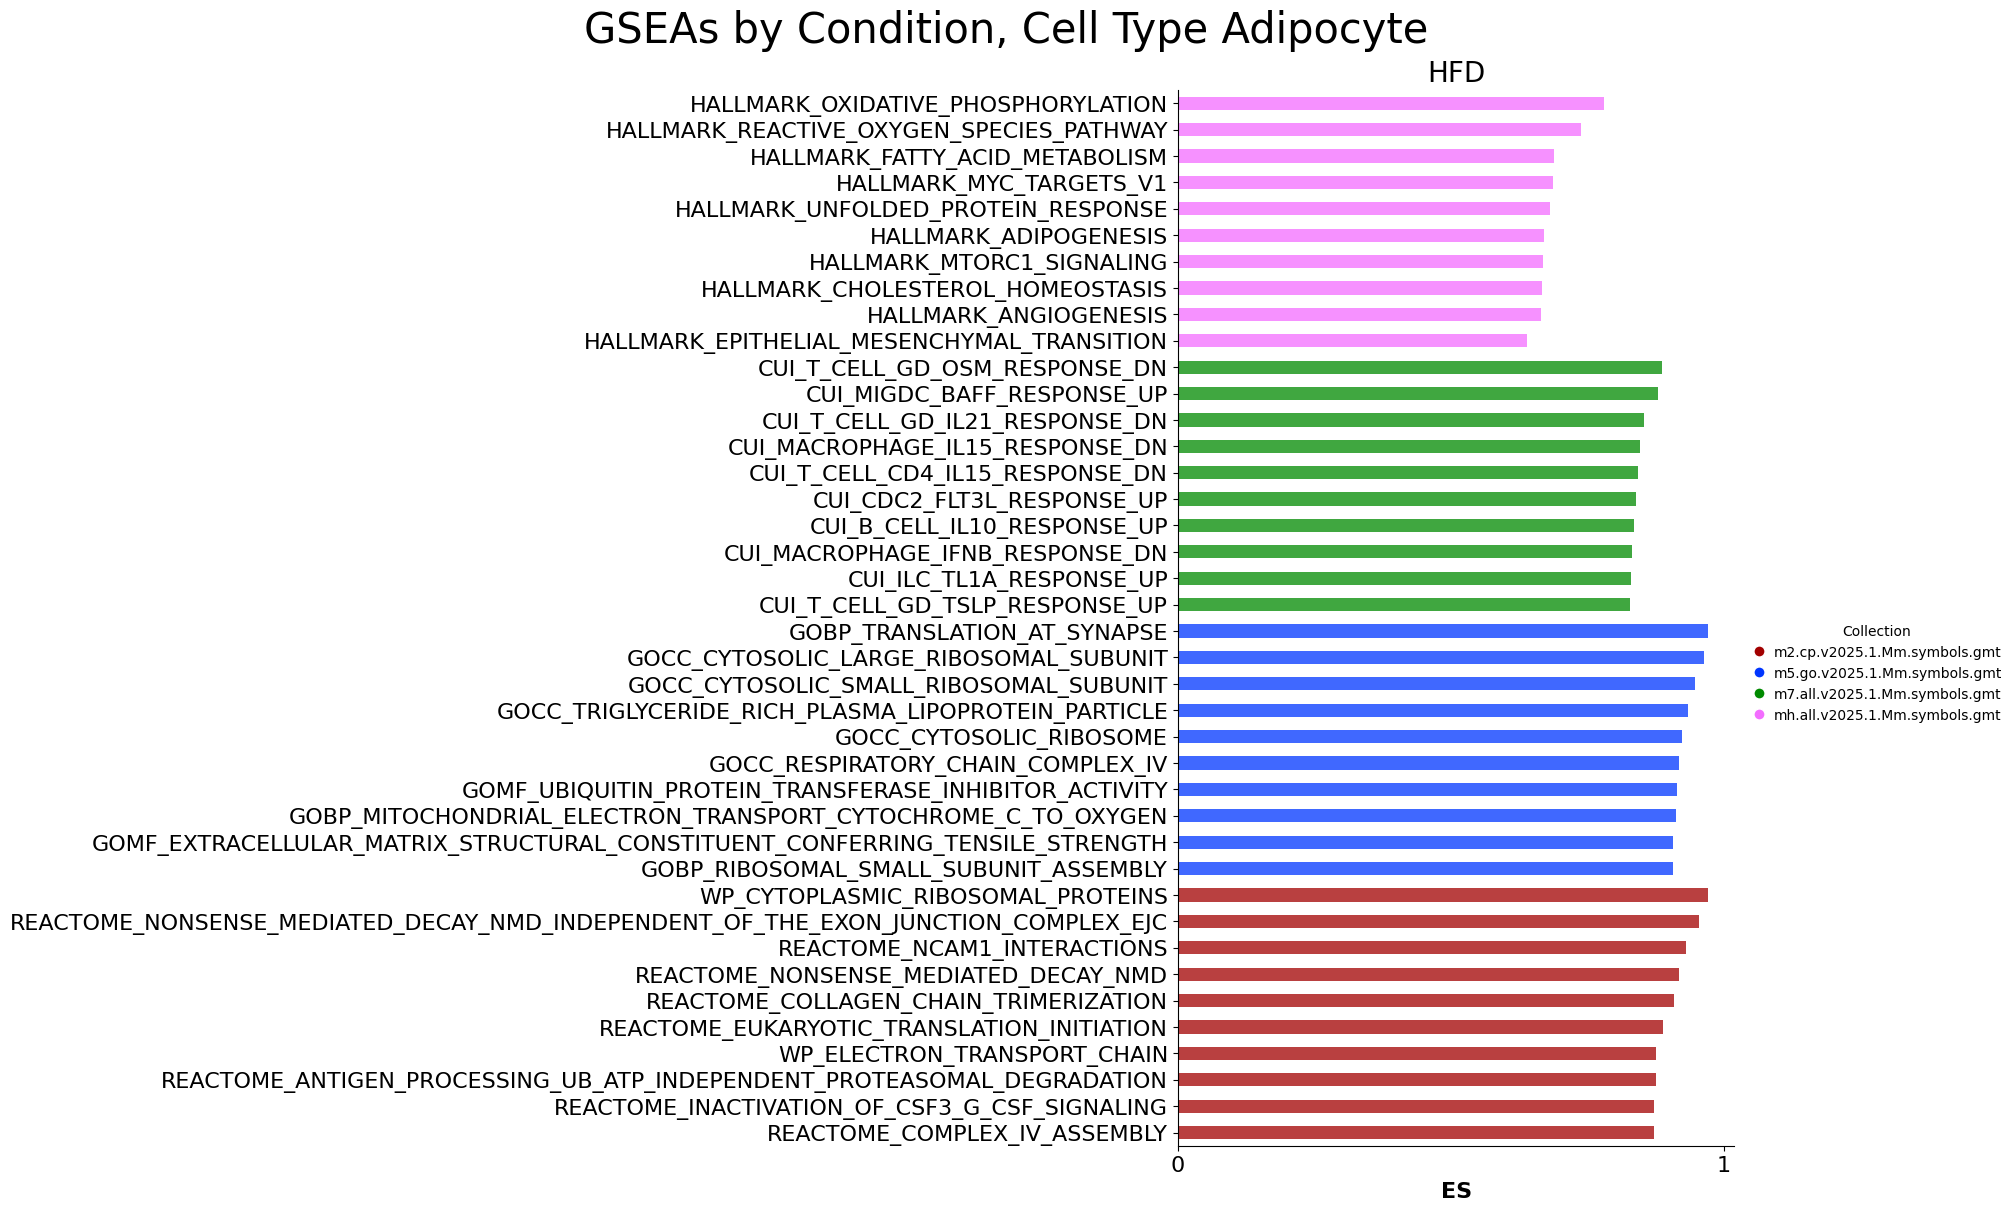

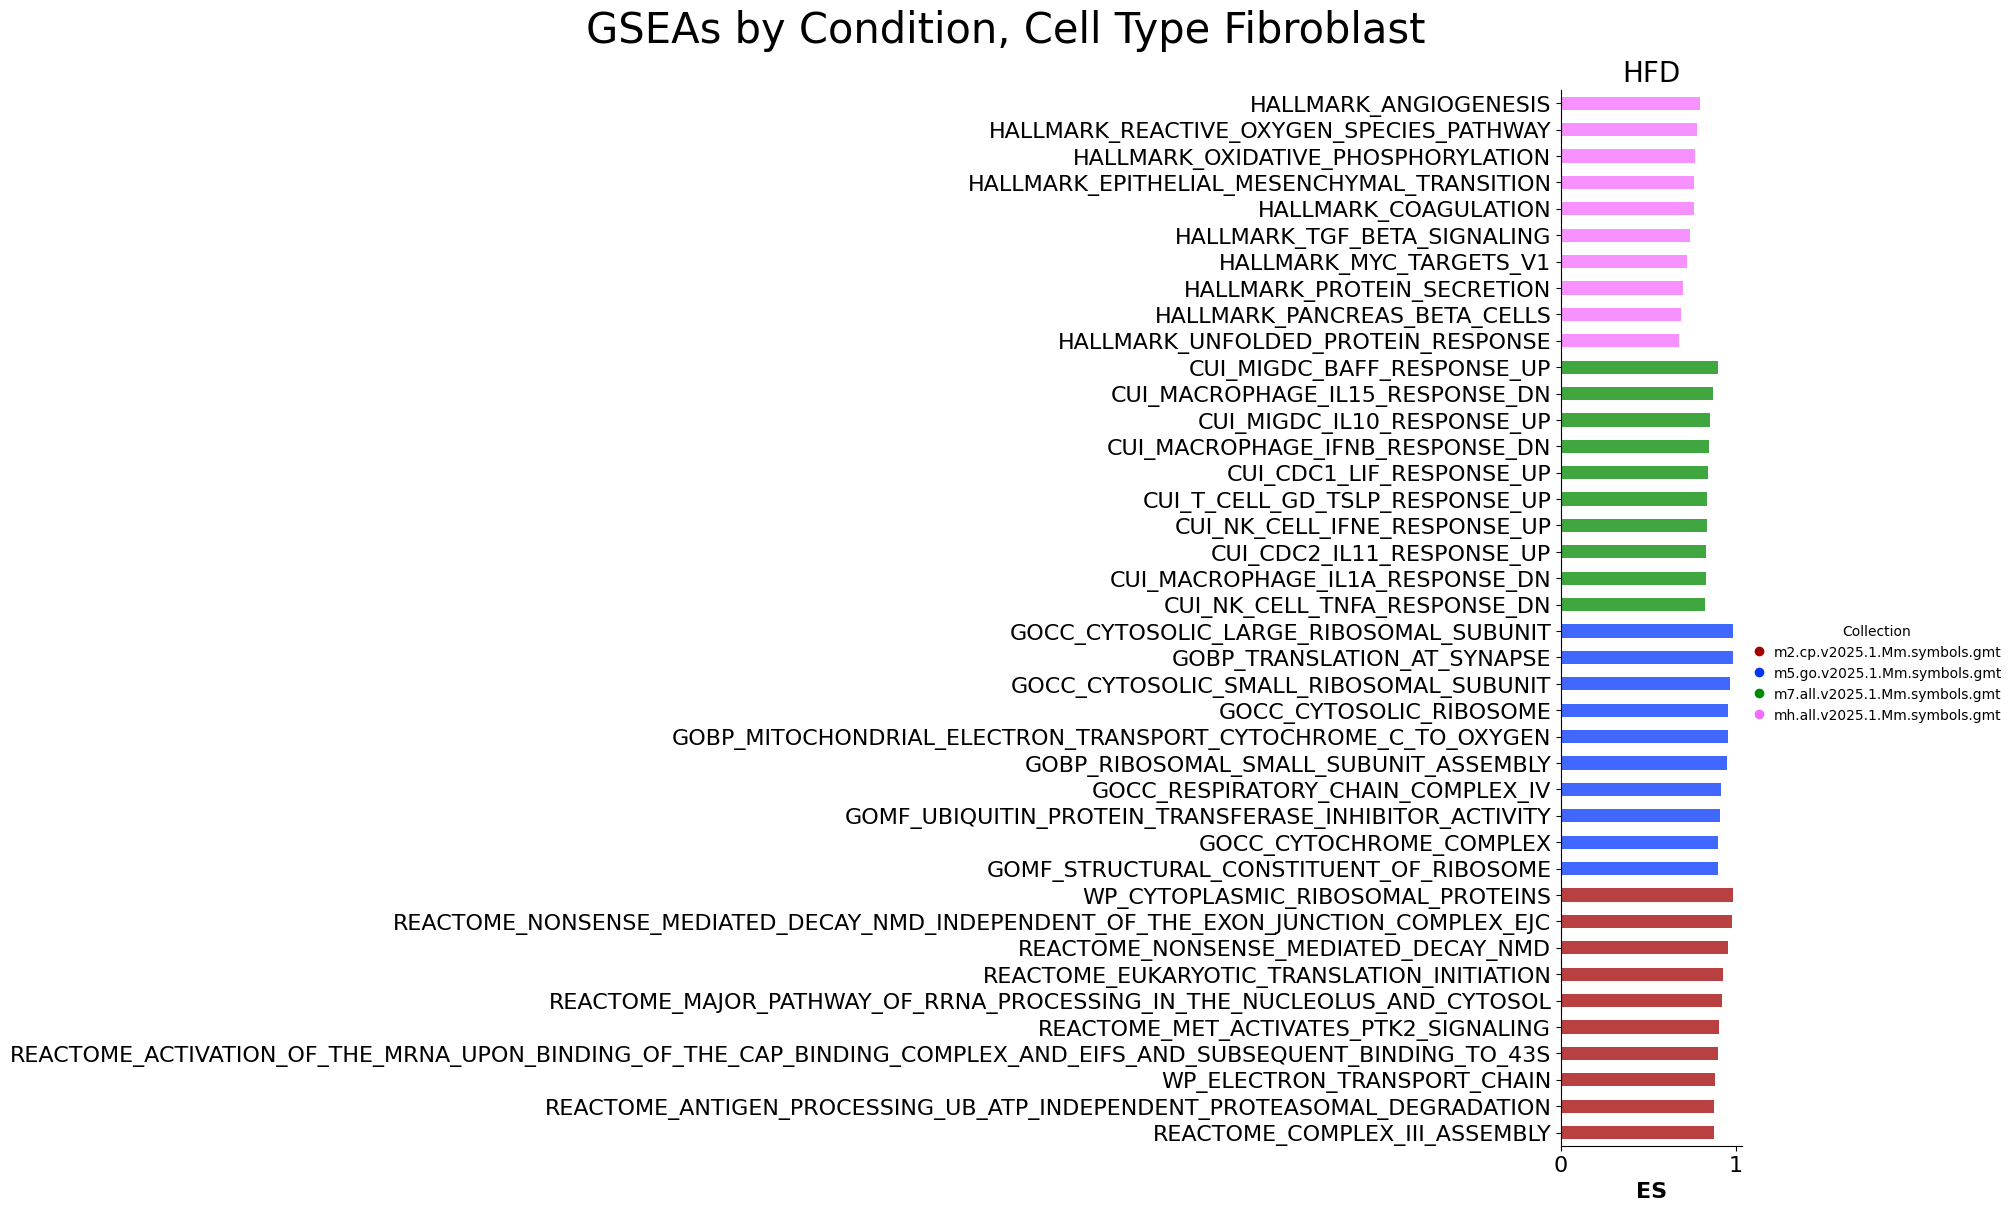

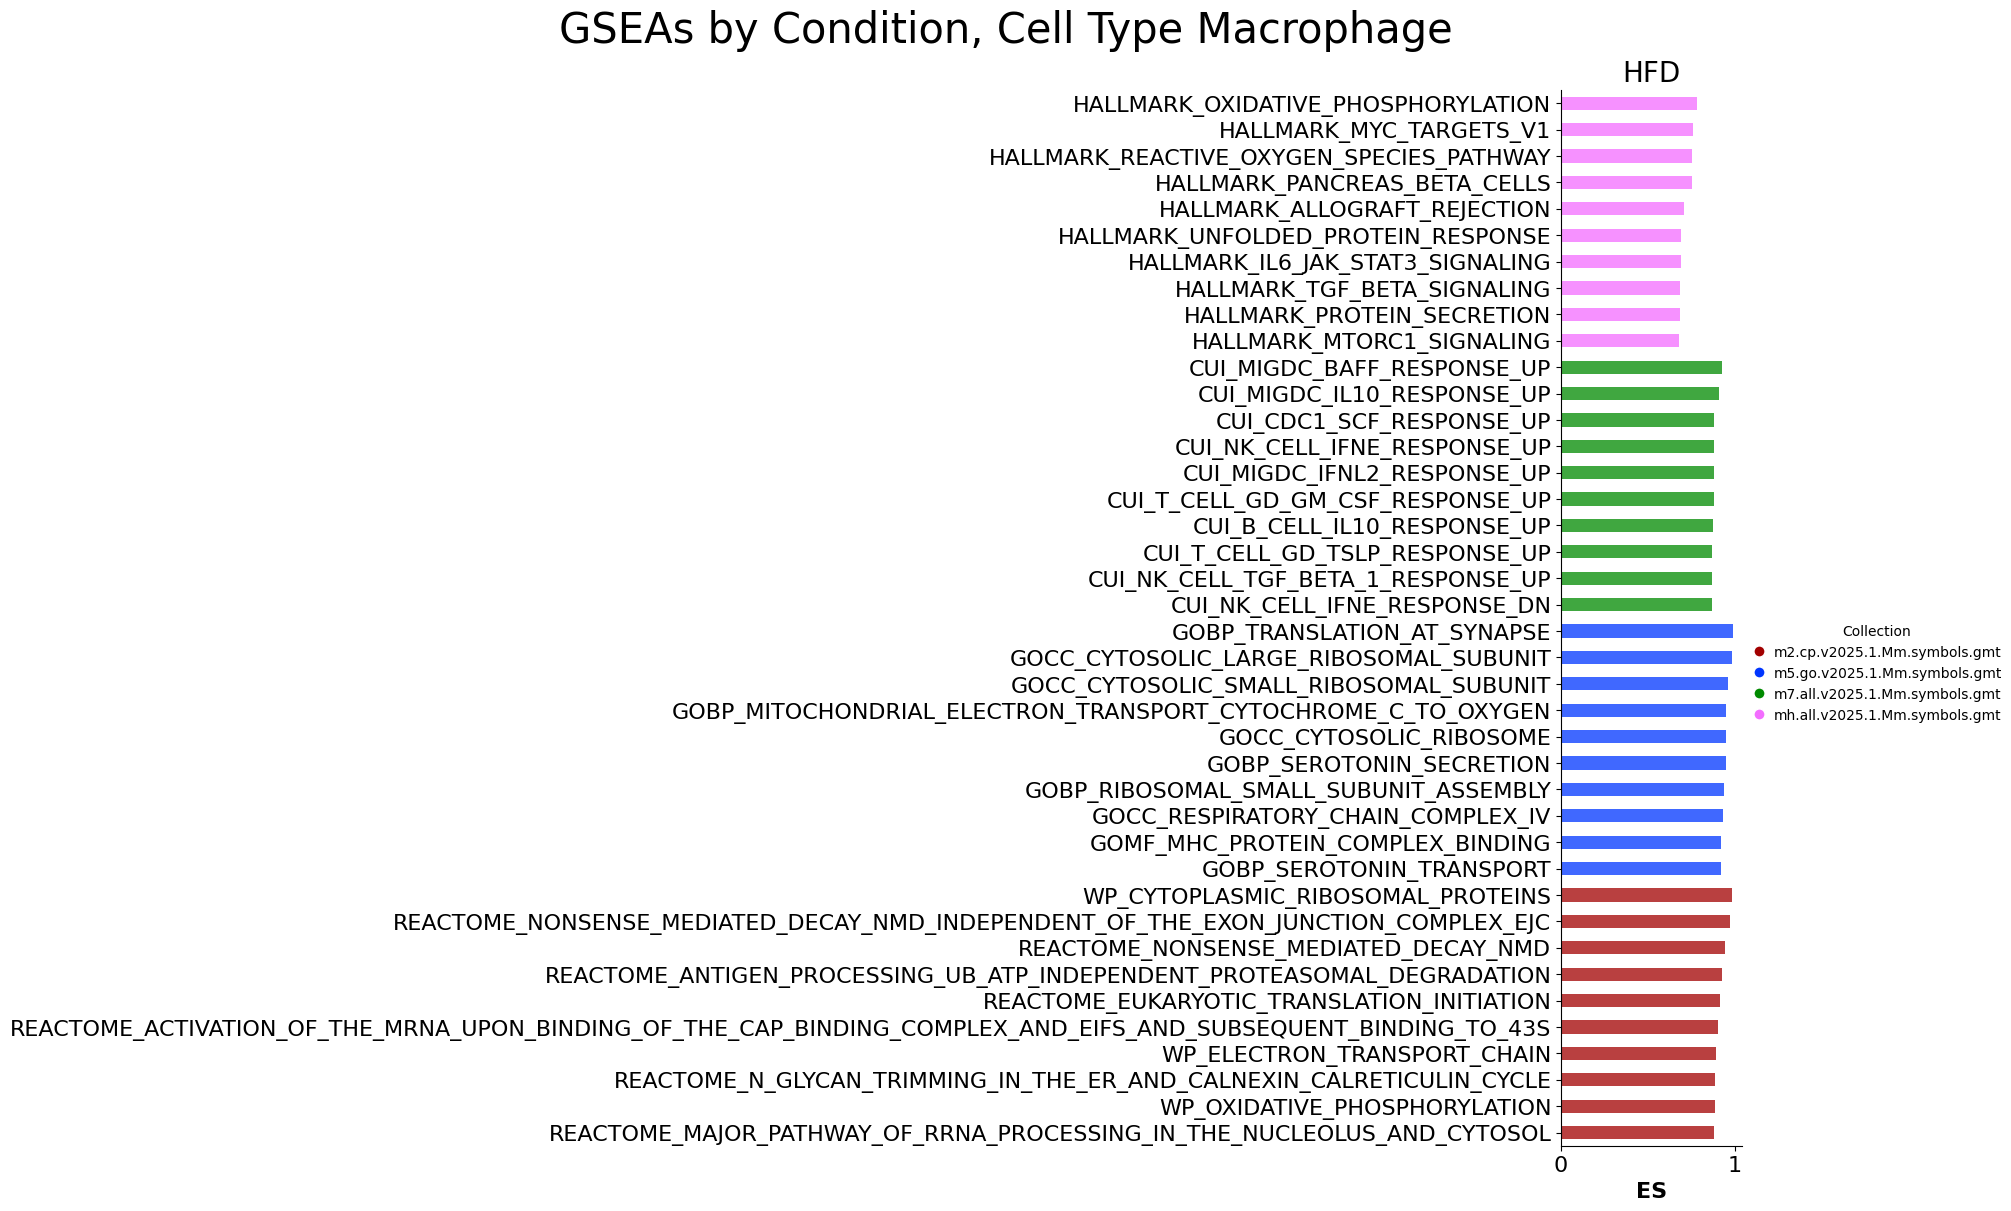

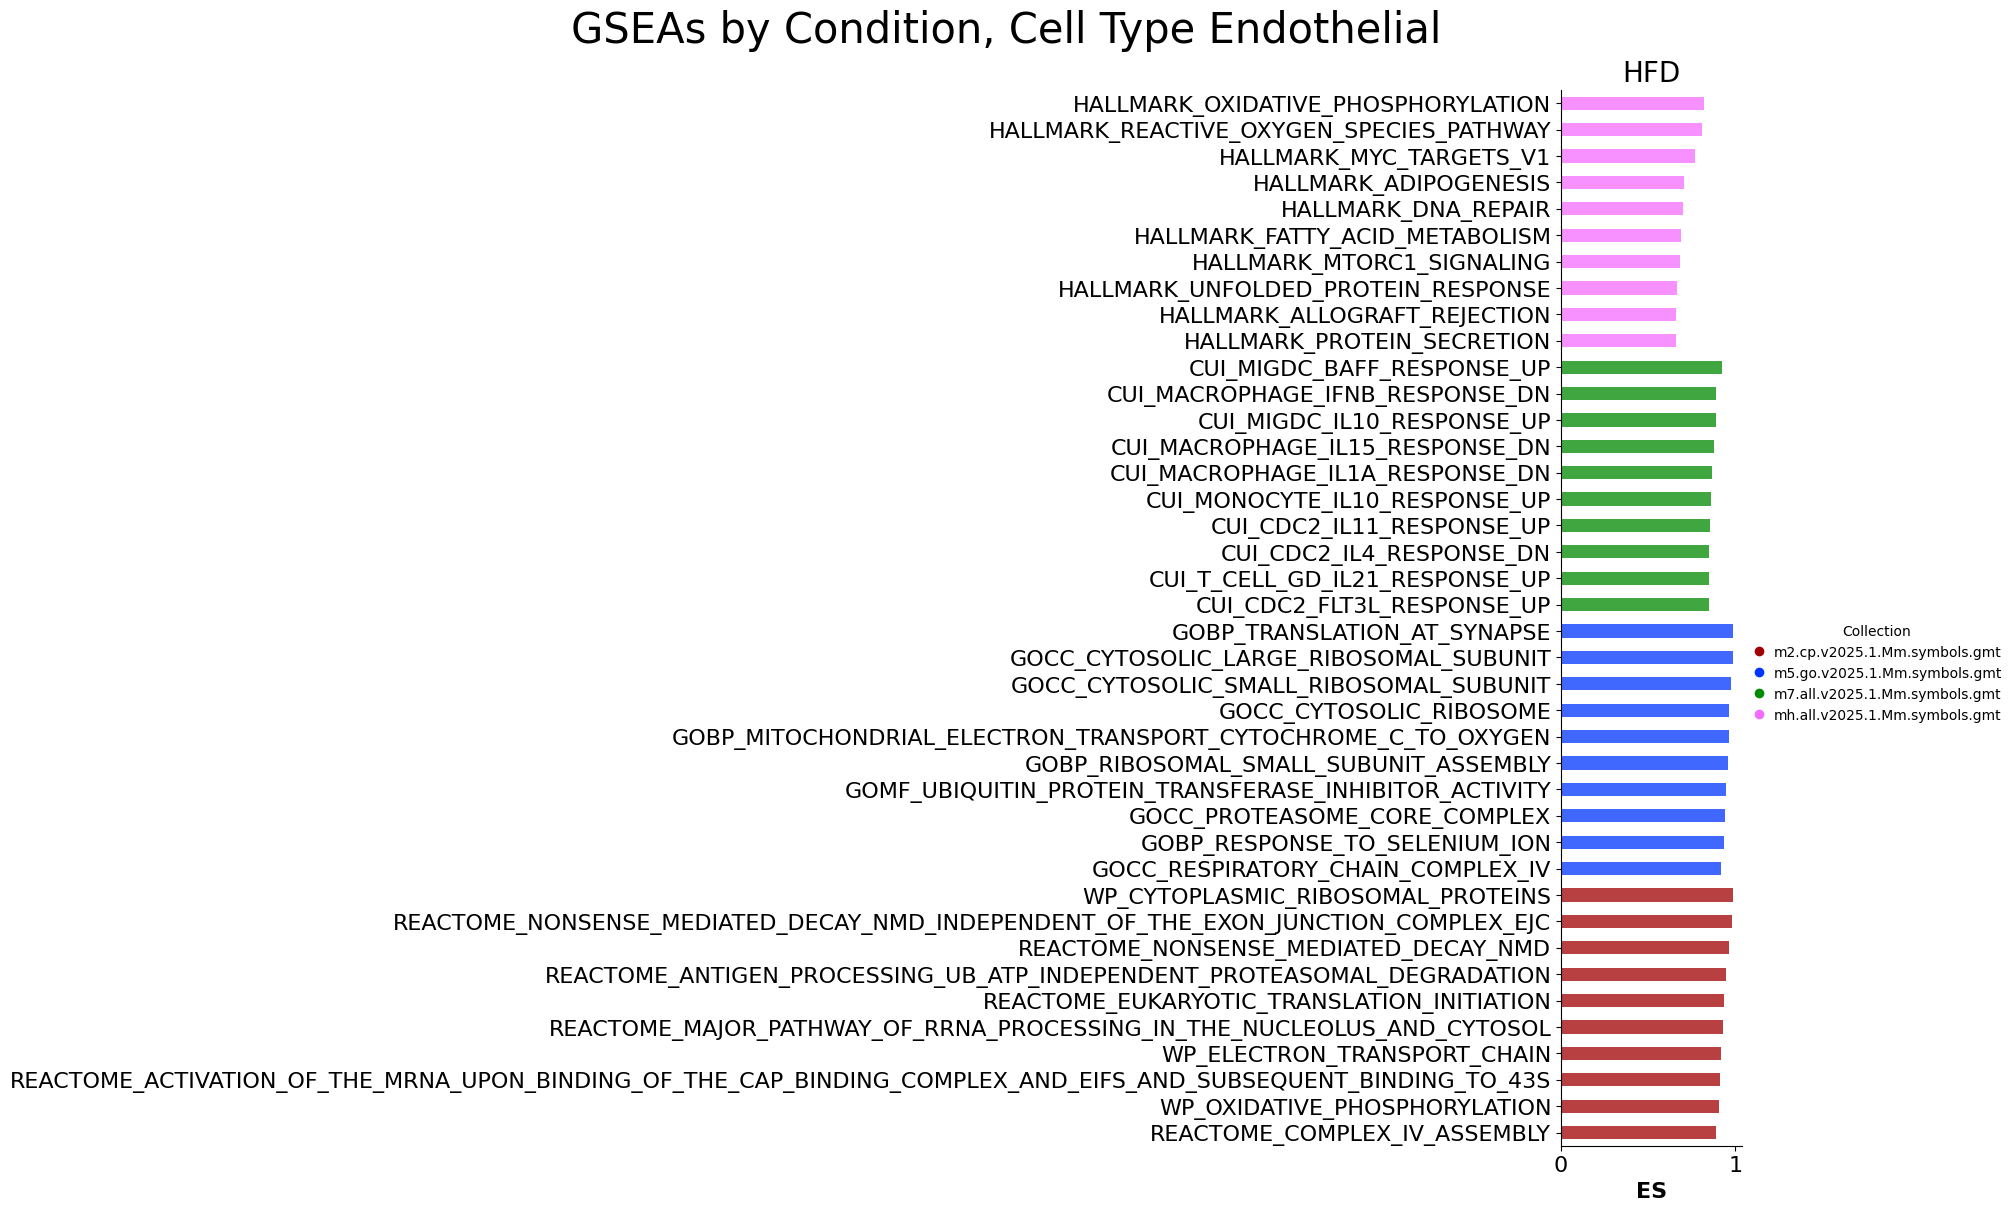

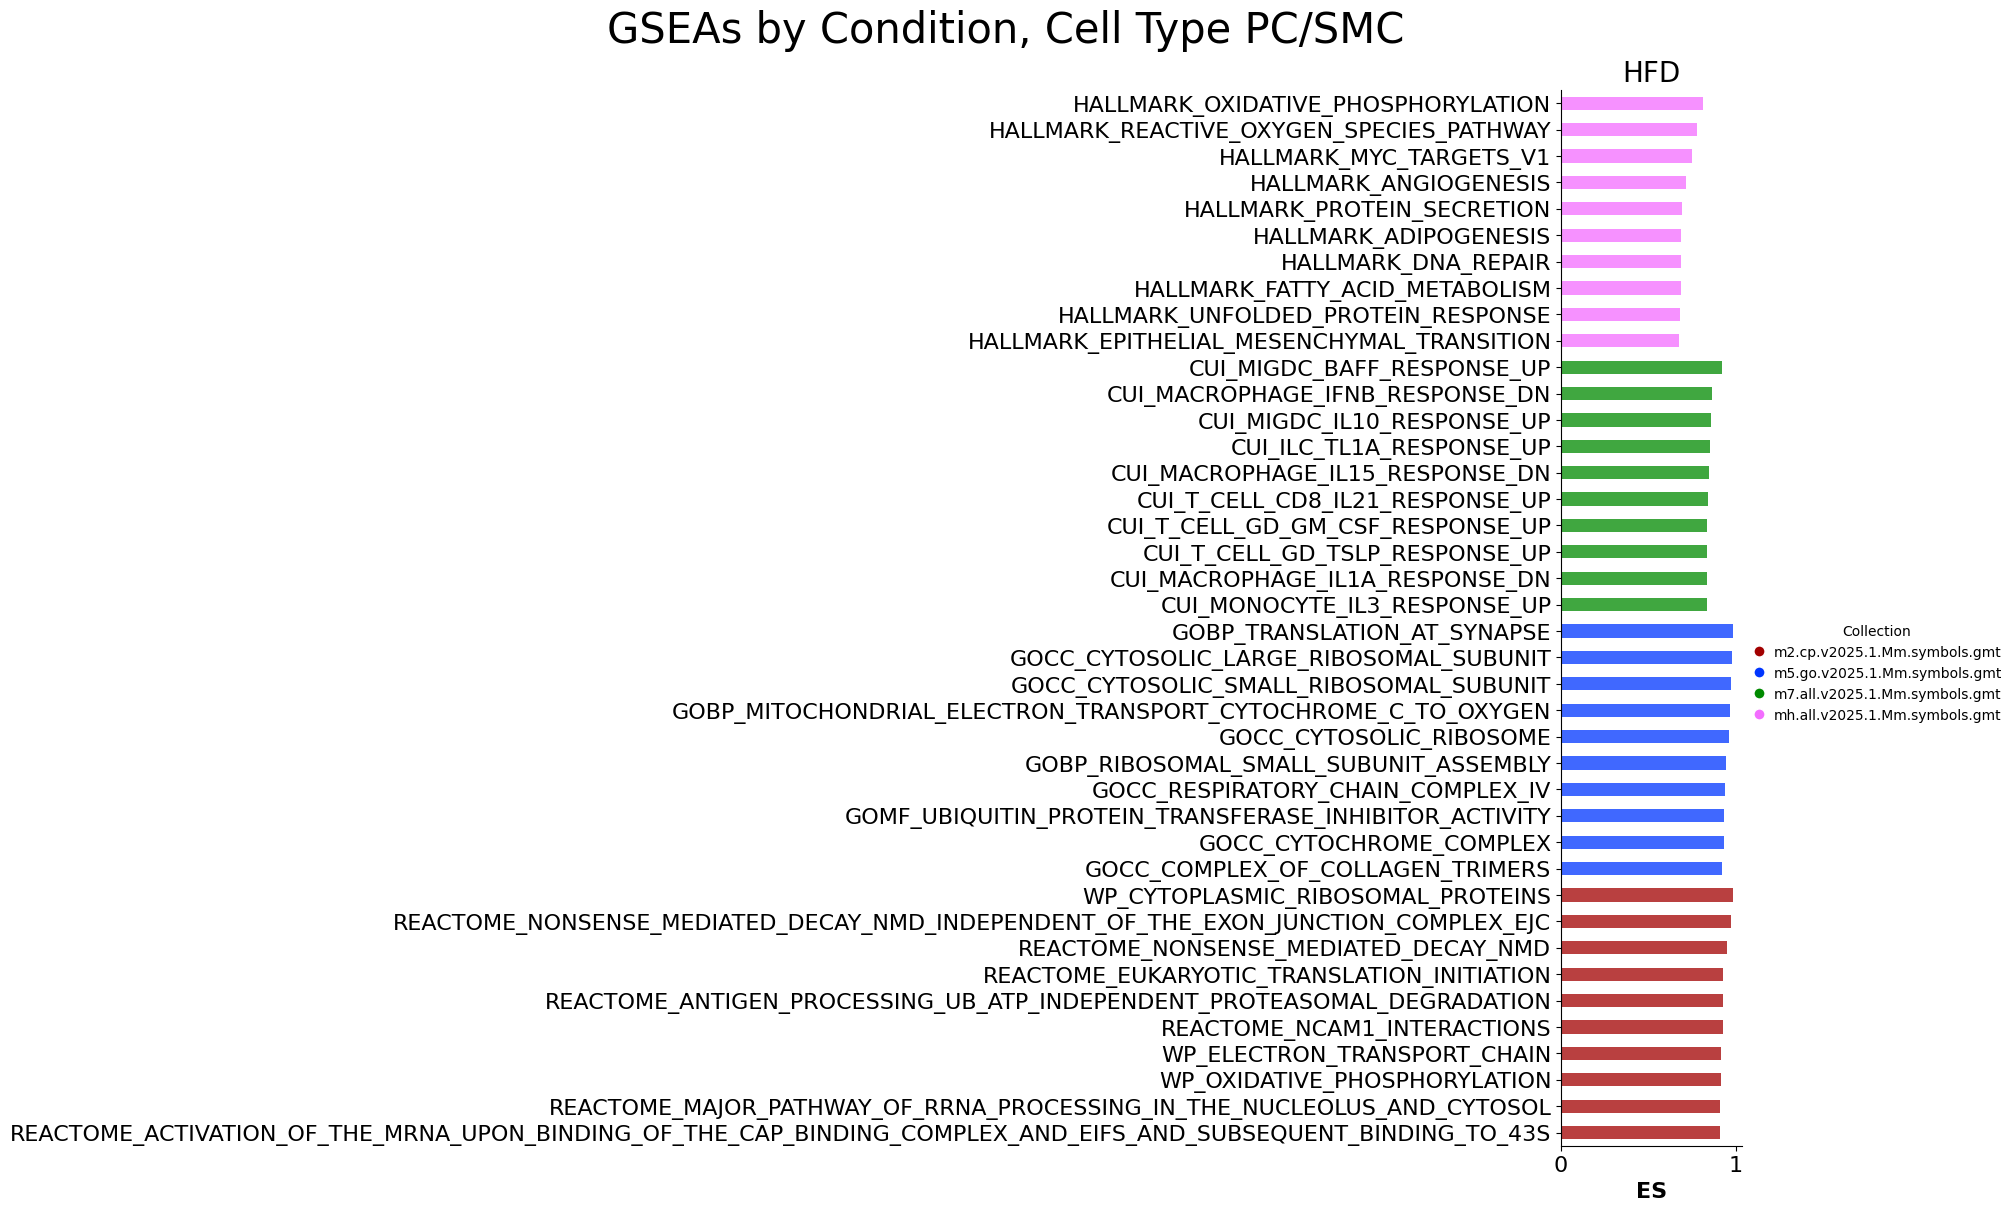

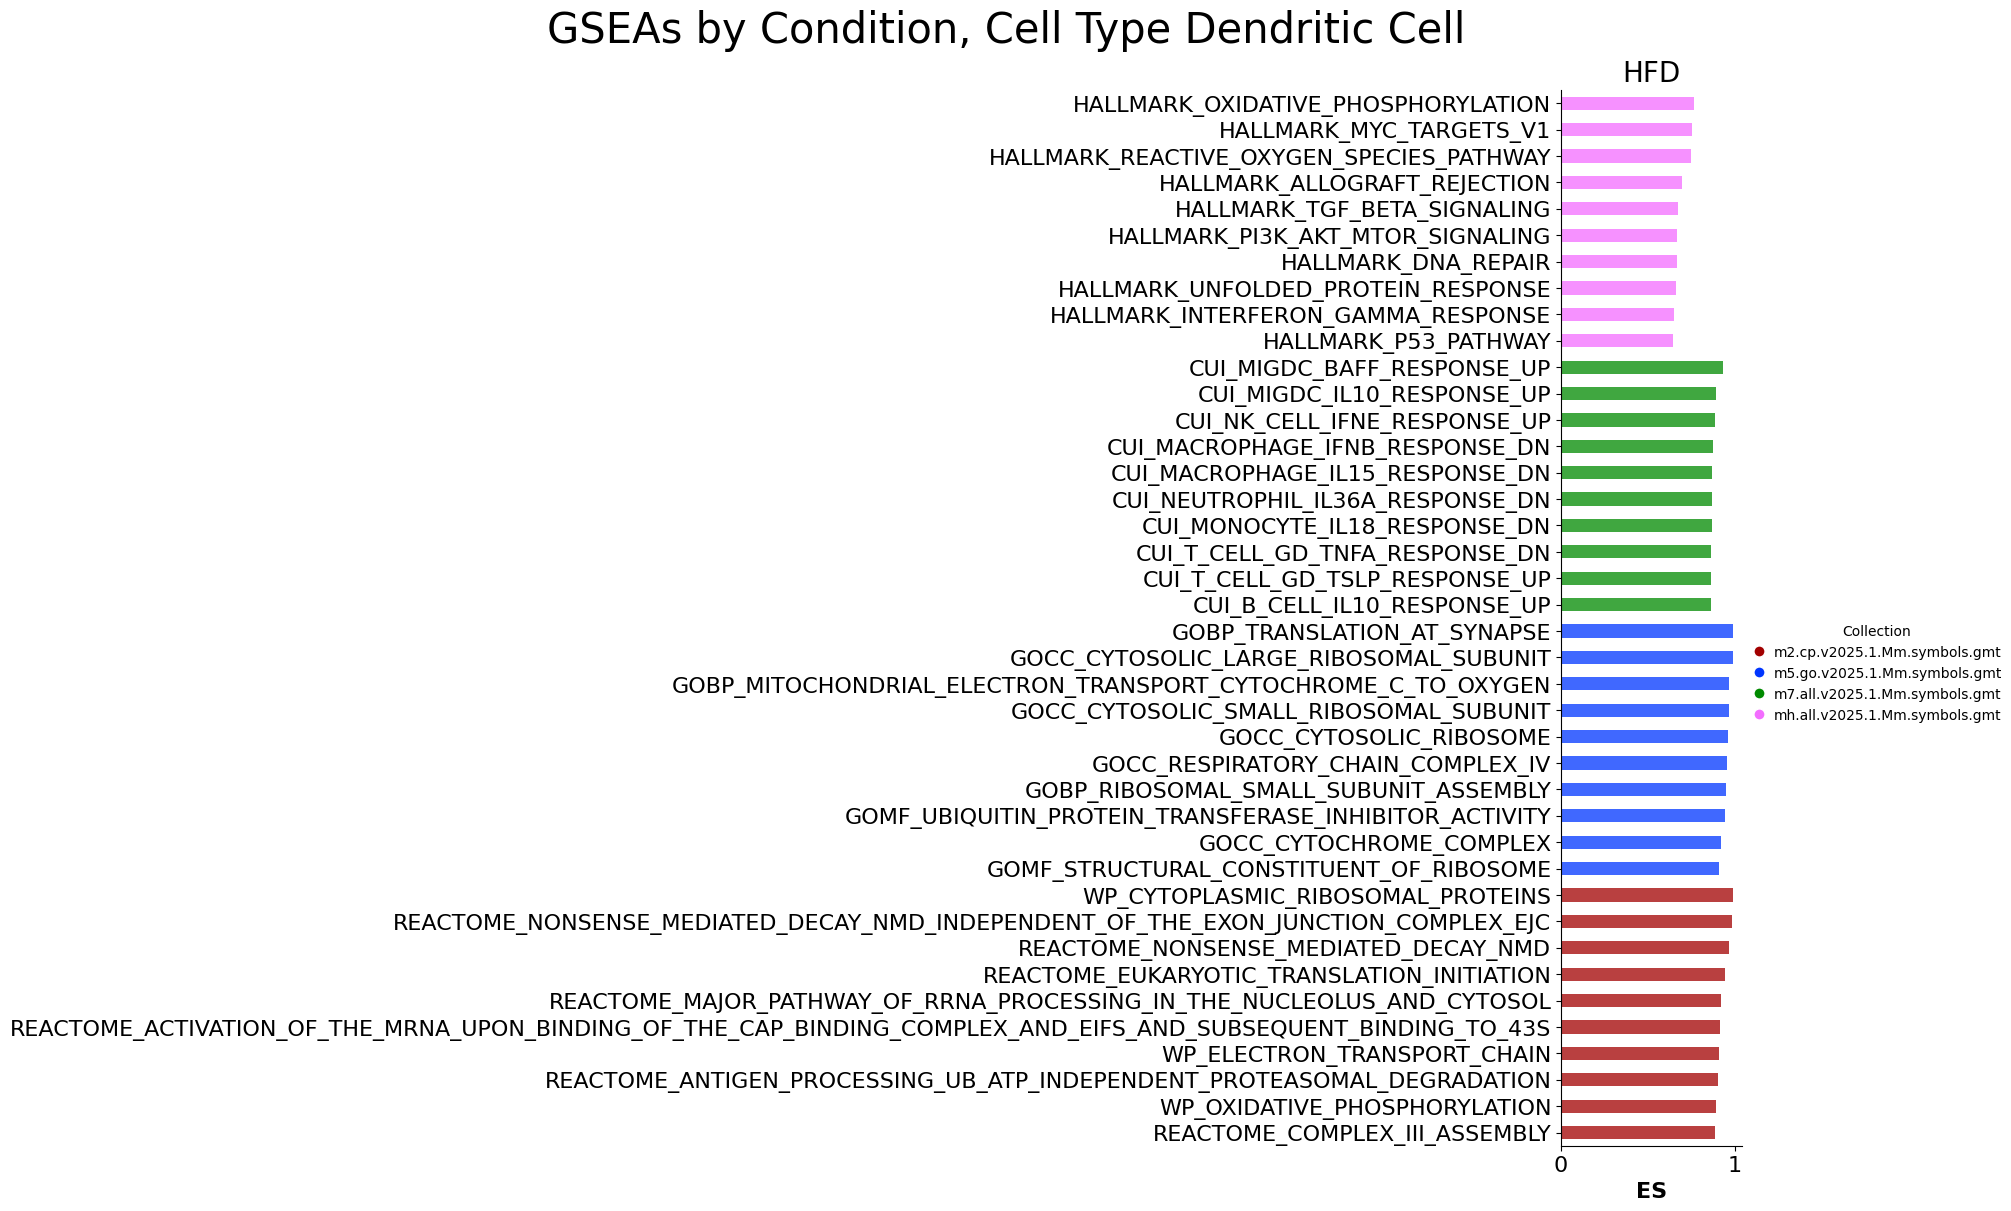

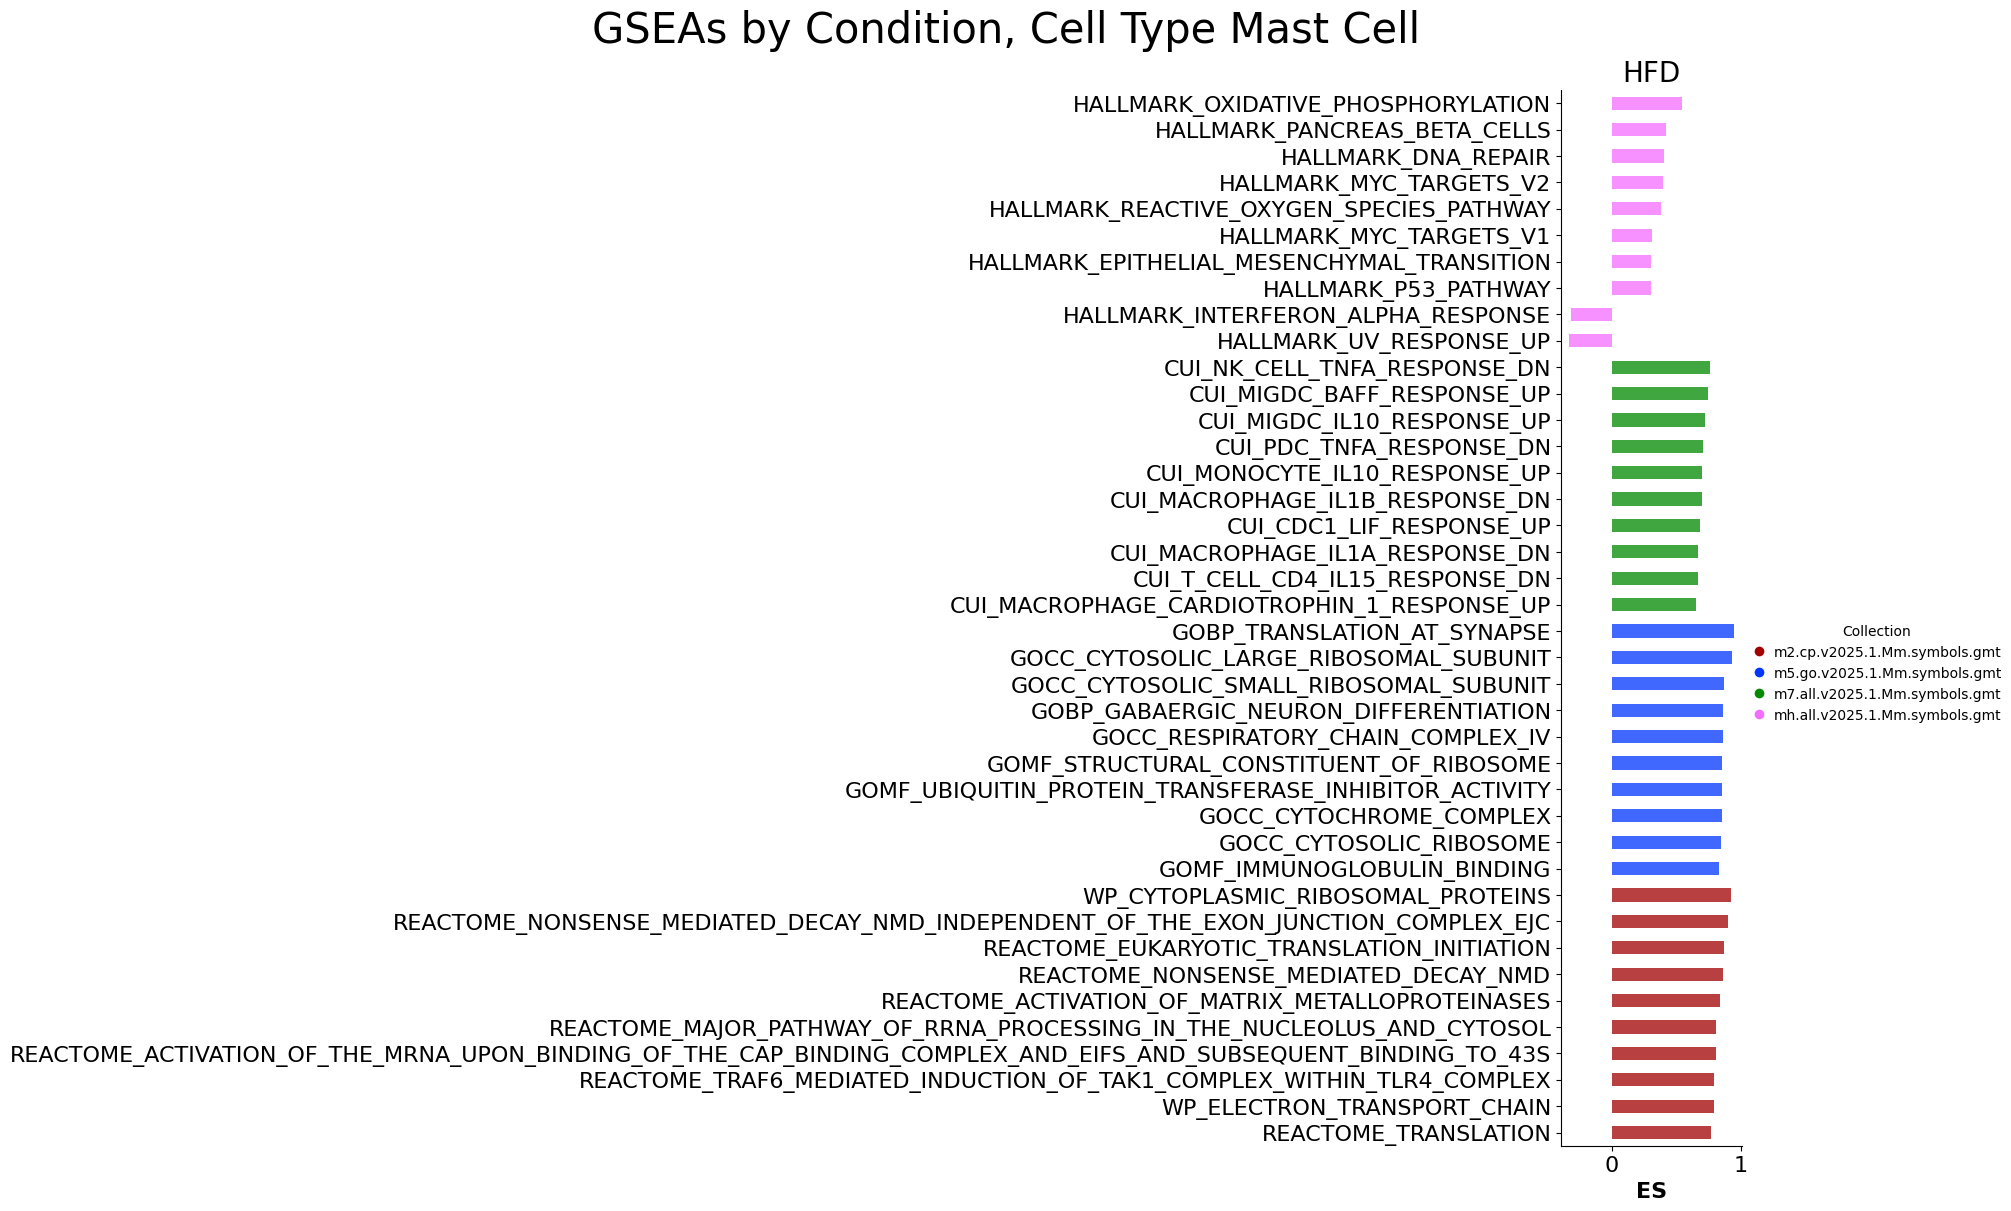

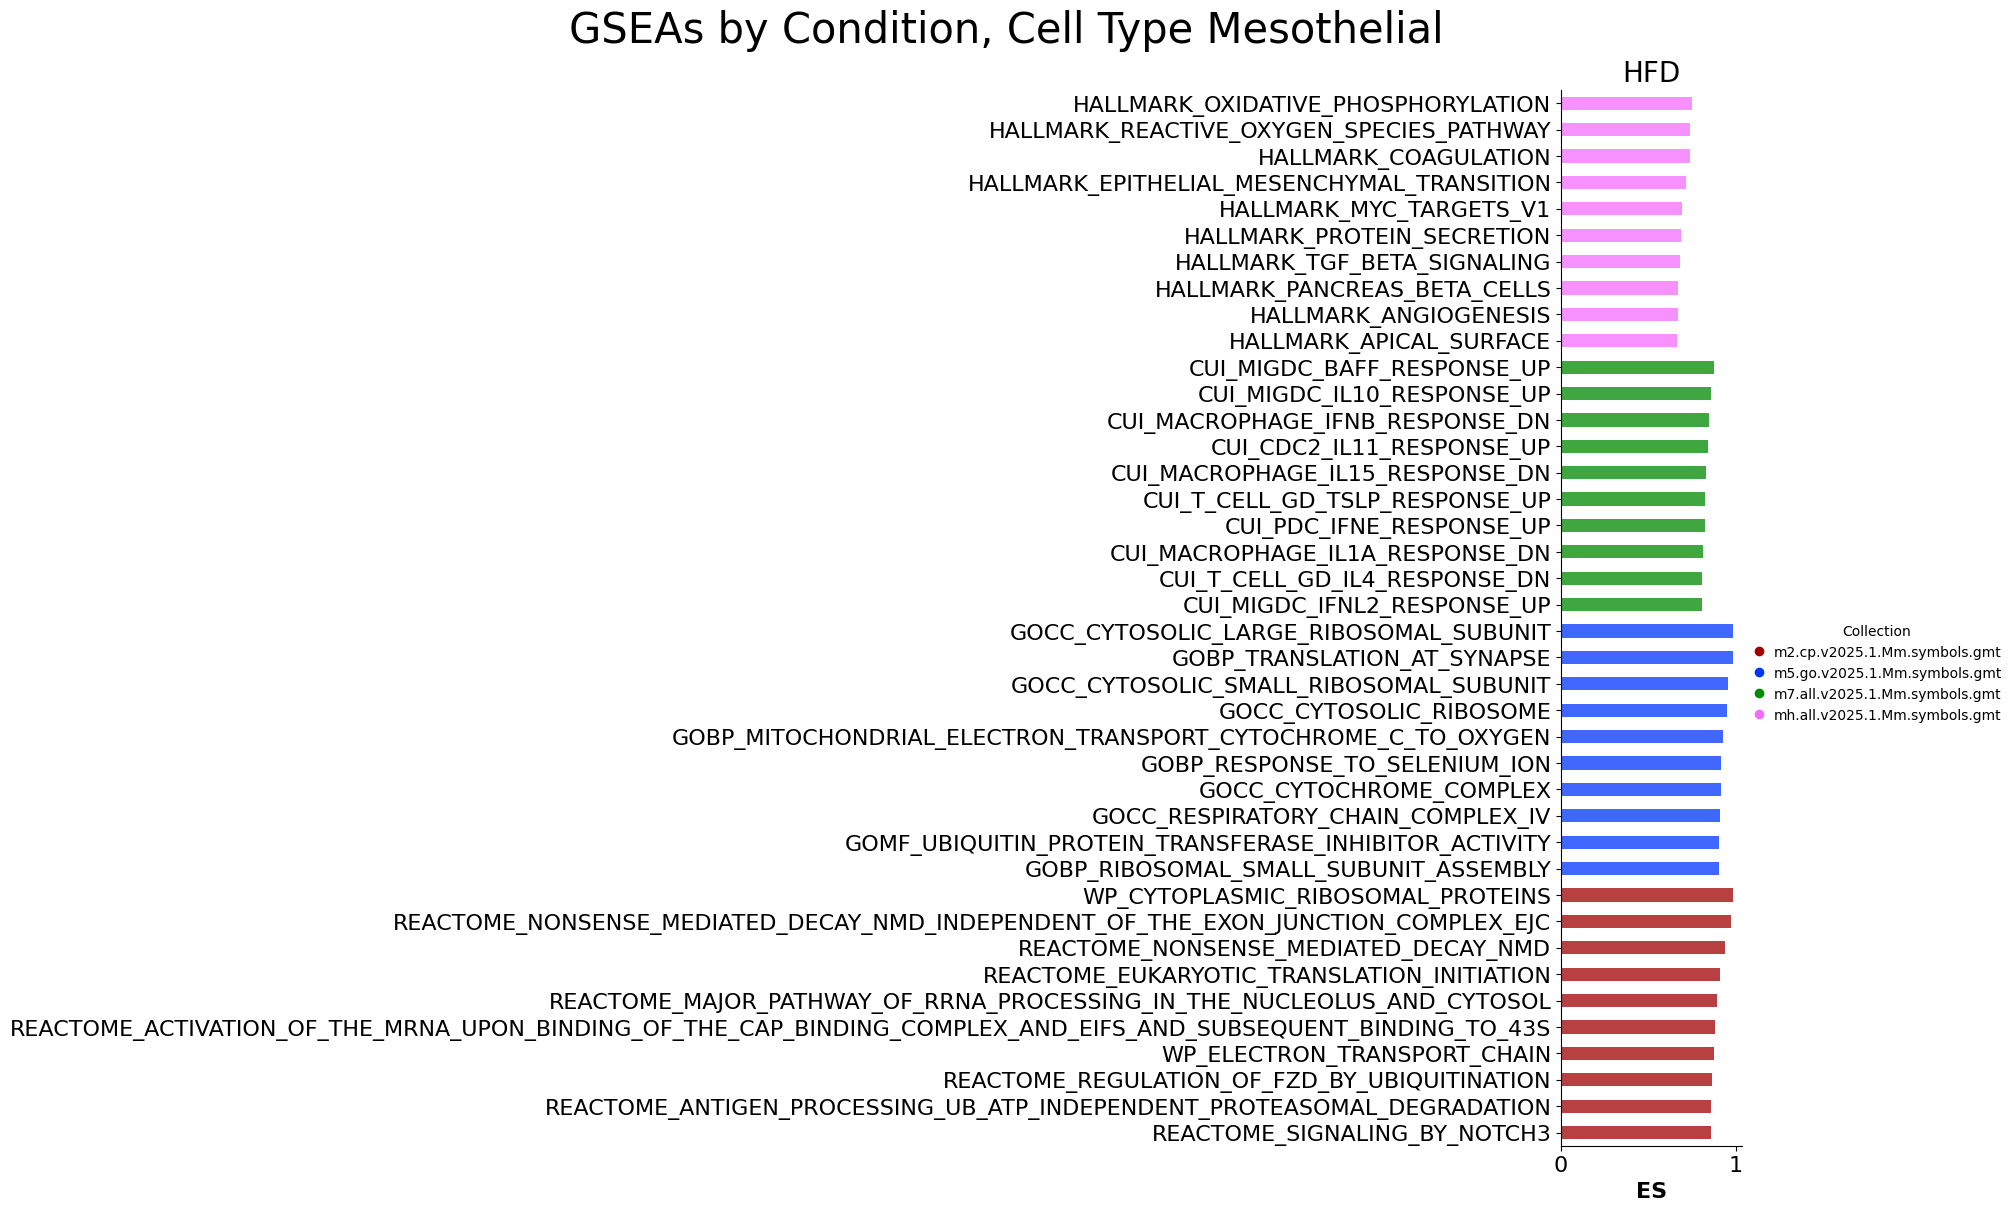

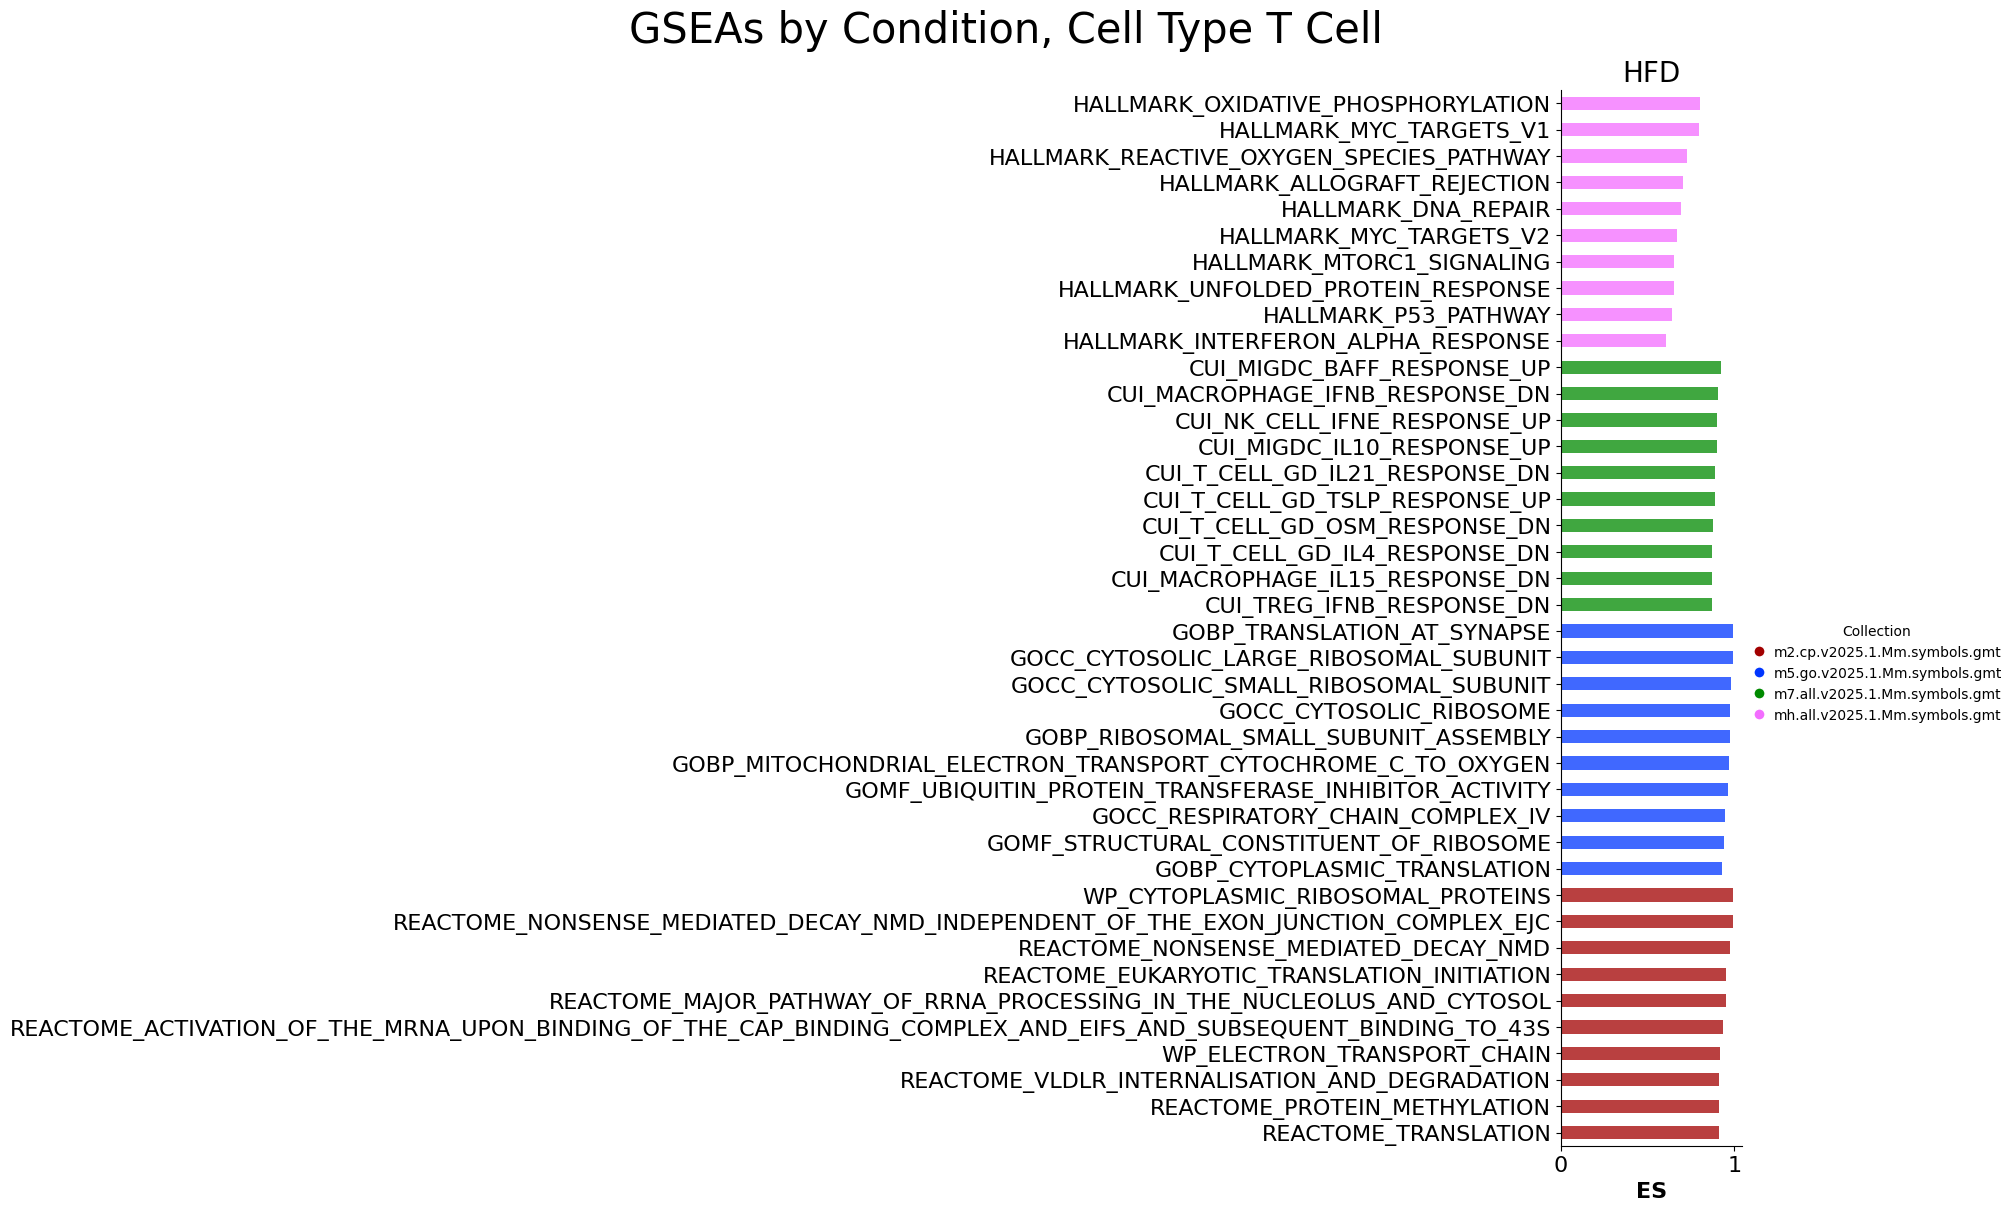

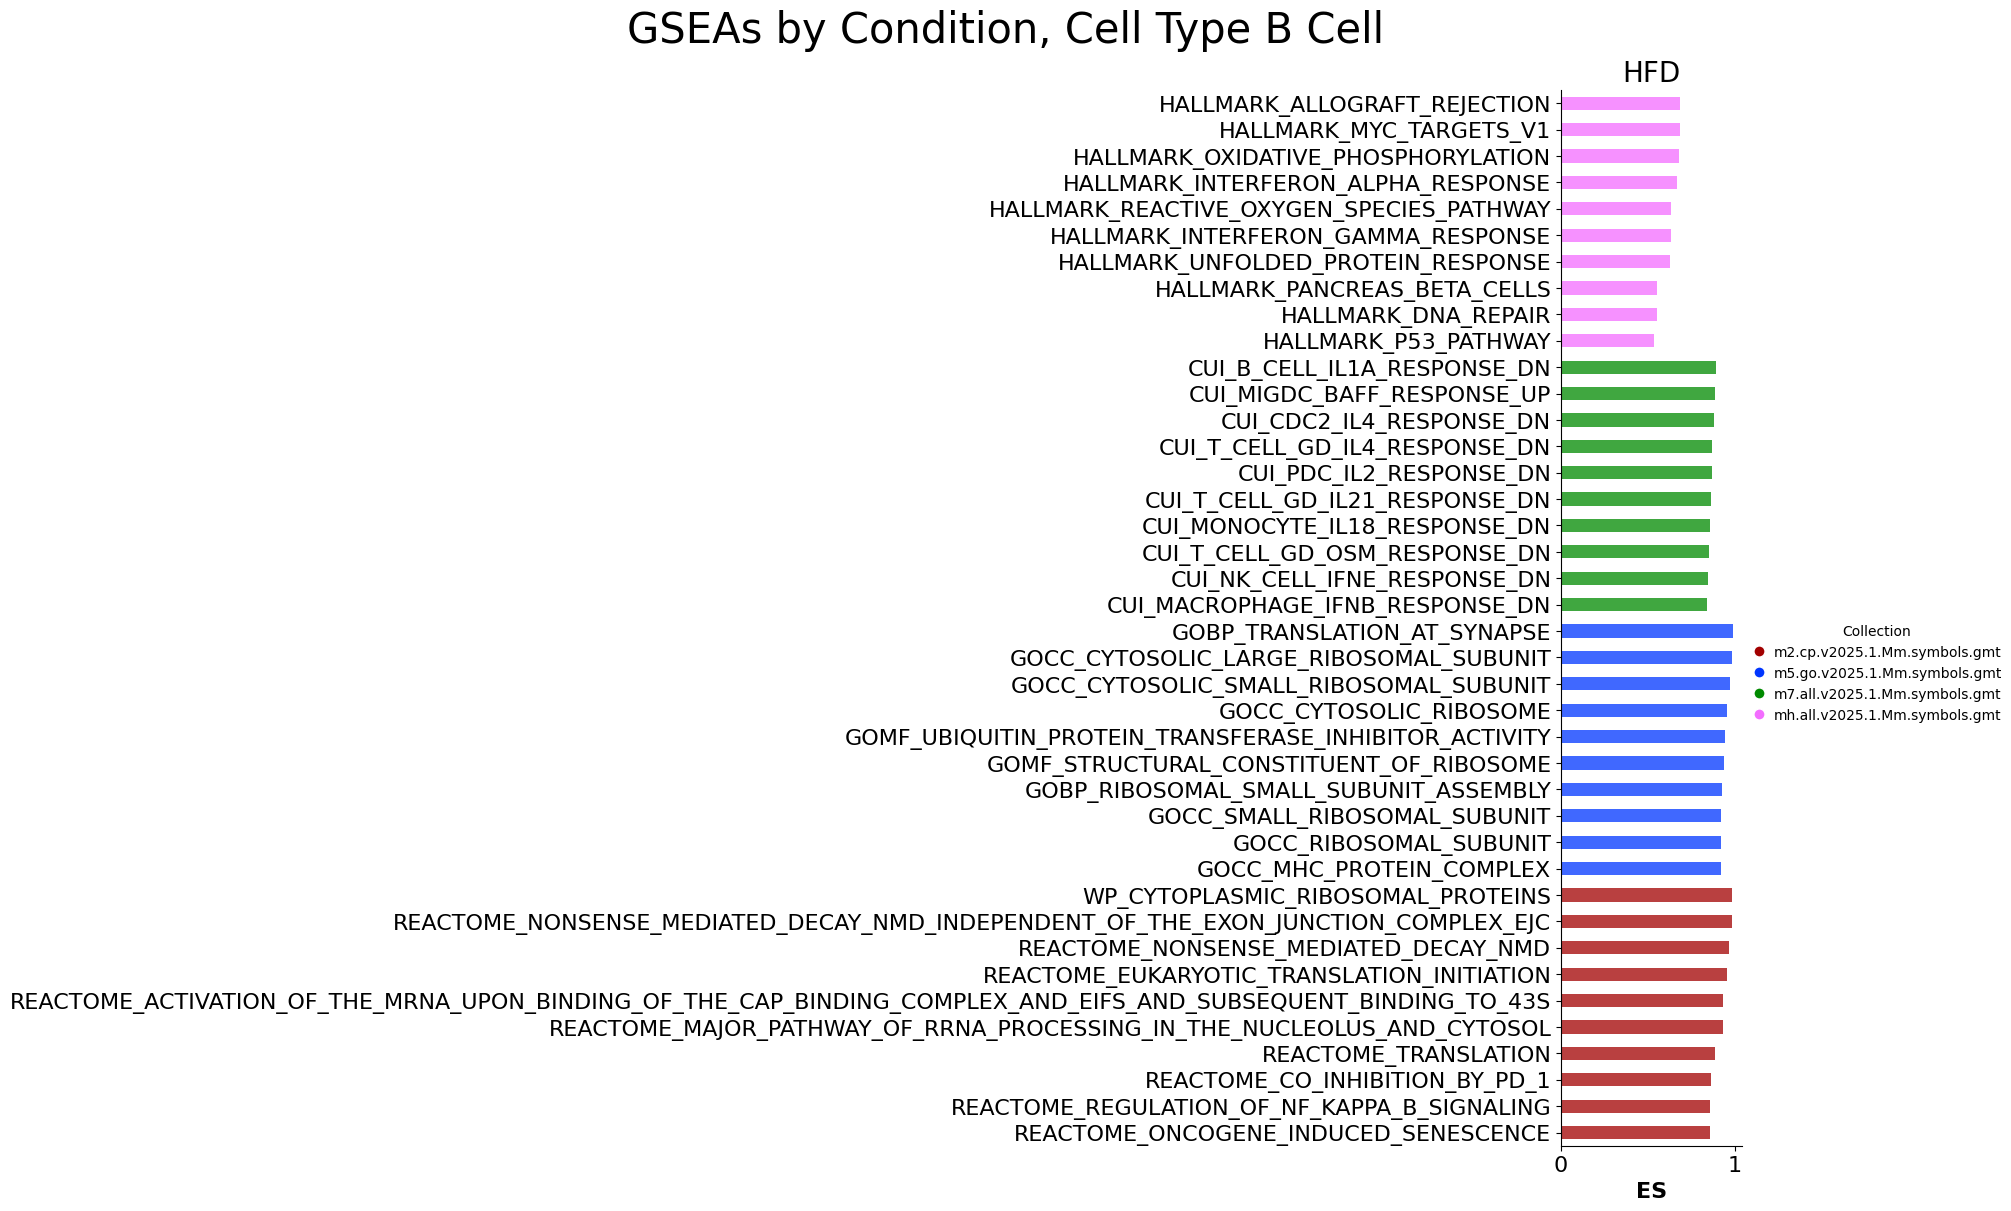

In [10]:
# GSEApy approach, by HFD/LFD per cluster
runGSEA = False

cluster_key = "cell_type"
condition_key = "Condition"
annotation = "manDoublet-seuratV3-harmony-leiden_1 - GSEA condition by celltype"
savedir = os.path.join(DATADIR, "processed", study, "py", "3_annotated")
os.makedirs(savedir, exist_ok=True)

custom_gsea = [
    os.path.join(ref_dir, "mh.all.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m2.cp.v2025.1.Mm.symbols.gmt"),
    # os.path.join(ref_dir,"m3.all.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m5.go.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m7.all.v2025.1.Mm.symbols.gmt"),
    # os.path.join(ref_dir, "m8.all.v2025.1.Mm.symbols.gmt"),
]
provided_gsea = []
total_gsea = custom_gsea + provided_gsea

if runGSEA is True:
    preranks = []
    clust_cond_gsea_results = {}

    for cluster in adata.obs[cluster_key].unique():
        # define subset
        cluster_adata = adata[adata.obs[cluster_key] == cluster]

        # run DEGs
        sc.tl.rank_genes_groups(
            cluster_adata,
            groupby="Condition",
            key_added=f"de_{cluster_key}-{cluster}_{condition_key}",
            use_raw=False,
            layer="normalized",
            method="wilcoxon",
        )

        clust_cond_gsea_results[cluster] = {}
        conds = cluster_adata.obs[condition_key].unique()
        if len(conds) > 2:
            for condition in conds:
                # access DEGs
                df = sc.get.rank_genes_groups_df(
                    cluster_adata,
                    group=condition,
                    key=f"de_{cluster_key}-{cluster}_{condition_key}",
                )
                ranking = df[["names", "scores"]]

                # run GSEA
                prerank = gp.prerank(
                    rnk=ranking,
                    gene_sets=total_gsea,
                    seed=6,
                    threads=7,
                    permutation_num=100,
                )

                # save result for plotting
                result = prerank.res2d
                names = result["Term"].str.split("__", expand=True)
                result["Collection"] = names[0]
                result["Term"] = names[1]
                clust_cond_gsea_results[cluster][condition] = result
        else:
            df = sc.get.rank_genes_groups_df(
                cluster_adata,
                group=conds[0],
                key=f"de_{cluster_key}-{cluster}_{condition_key}",
            )
            ranking = df[["names", "scores"]]

            # run GSEA
            prerank = gp.prerank(
                rnk=ranking,
                gene_sets=total_gsea,
                seed=6,
                threads=7,
                permutation_num=100,
            )

            # save result for plotting
            result = prerank.res2d
            names = result["Term"].str.split("__", expand=True)
            result["Collection"] = names[0]
            result["Term"] = names[1]
            clust_cond_gsea_results[cluster][conds[0]] = result

    with open(os.path.join(savedir, f"{annotation}.pickle"), "wb") as handle:
        pickle.dump(clust_cond_gsea_results, handle)
    with open(os.path.join(savedir, f"{annotation}.pickle"), "rb") as handle:
        cond_gsea_results = pickle.load(handle)

else:
    with open(os.path.join(savedir, f"{annotation}.pickle"), "rb") as handle:
        cond_gsea_results = pickle.load(handle)

# plot
collection_cols = color_gen(pd.Series(total_gsea))
for n, cluster in enumerate(clust_cond_gsea_results):
    f, ax = plt.subplots(1, 1, figsize=(20, 12), layout="constrained")
    for m, condition in enumerate(clust_cond_gsea_results[cluster]):
        gp.plot.barplot(
            clust_cond_gsea_results[cluster][condition],
            "ES",
            group="Collection",
            top_term=10,
            ax=ax,
            color=collection_cols,
        )
        ax.set_title(f"{condition}", size=20)
    f.suptitle(f"GSEAs by Condition, Cell Type {cluster}", size=30)

In [ ]:
cluster = "1"
condition = "HFD"
gs_res = clust_cond_gsea_results[str(cluster)][condition]

for coll in collections:
    tmp = gs_res[gs_res["Term"].isin([coll])]
    lead_genes = tmp["Lead_genes"].str.split(";", expand=True)
    lead_genes = pd.Series(lead_genes.to_numpy().flatten()).dropna().unique()
    f = sc.pl.embedding(ewat_fibros, basis='LocalMAP_fibro', color=lead_genes, ncols=8, return_fig=True)
    f.suptitle(f"{coll} Lead Genes ($ES={float(tmp["NES"]):.2f}, FDR={float(tmp["FDR q-val"]):.2f}$)",
               size=40)

In [ ]:
results = []
for cluster in clust_cond_gsea_results:
    tmp = clust_cond_gsea_results[cluster]["HFD"]
    tmp = tmp[tmp["Term"].isin(collections)][
        ["Term", "NES", "NOM p-val", "FDR q-val", "Lead_genes"]
    ]
    tmp["Cell Type"] = cluster
    results.append(tmp)
results = pd.concat(results)
results.to_csv("gseas by celltype (hfd vs lfd).csv")

#### Decoupler

In [ ]:
# Decoupler method
run_GSEA = True

# get geneset info
gsea_sets = {
    "FIBRO_MSigDB-MH" : os.path.join(ref_dir,"mh.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M2-CP" : os.path.join(ref_dir,"m2.cp.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M3" : os.path.join(ref_dir,"m3.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M5-GO" : os.path.join(ref_dir,"m5.go.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M7" : os.path.join(ref_dir,"m7.all.v2025.1.Mm.symbols.gmt"), 
    "FIBRO_MSigDB-M8" : os.path.join(ref_dir,"m8.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_CollecTRI" : dc.op.collectri(organism='mouse')
}

# run GSEA
if run_GSEA is True:
    for name, geneset in gsea_sets.items():
        if type(geneset) is str:
            GSEA_decoupler(adata, name, type="ULM", geneset_dir=geneset, remove_prefix=False)
        else:
            GSEA_decoupler(adata, name, type="ULM", geneset=geneset)

# plot
f = plt.figure(figsize=(len(gsea_sets)*8,10), layout="constrained")
sf = f.subfigures(1,len(gsea_sets))
for name in gsea_sets.keys():
    clear_uns(adata, "dendrogram")
    clear_uns(adata, "colors")
    plot_gsea_dc(adata, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_fibro_group', 30, name)

In [ ]:
gsea_sets_2 = {"FIBRO_MSigDB-MH" : os.path.join(ref_dir,"mh.all.v2025.1.Mm.symbols.gmt")}
for name, geneset in gsea_sets_2.items():
    GSEA_decoupler(adata, name, type="AUCell", geneset_dir=geneset, remove_prefix=False)

score = dc.pp.get_obsm(adata=adata, key="FIBRO_MSigDB-MH_score_aucell")
sc.pl.embedding(score, basis='LocalMAP_fibro', color=collections)

### Save/Load

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony-annotated_all_leiden1"
savedir = os.path.join(DATADIR,'processed',study,'py','3_annotated')
os.makedirs(savedir, exist_ok=True)
adata.write(os.path.join(savedir,f'{annotation}.h5ad'))

In [5]:
# load
annotation = "manDoublet-seuratV3-harmony-annotated_all_leiden1"
adata = sc.read_h5ad(
    os.path.join(DATADIR, "processed", study, "py", "3_annotated", f"{annotation}.h5ad")
)

##### Create Cloupe

In [ ]:
tmp_obsm = adata.obsm.copy()
for obsm in pd.Series(tmp_obsm.keys())[~pd.Series(tmp_obsm.keys()).isin(["LocalMAP", "X_pca", "X_umap", "integrated"])]:
    del tmp_obsm[obsm]

export = sc.AnnData(X = adata.layers["counts"].copy(),
                    obs = adata.obs[["Identifier", "Groups", "Condition", "Sample Type", "leiden", "cell_type", 'predicted_doublet-scDblFinder', 'predicted_doublet-DoubletFinder', 'predicted_doublet-doubletdetection', 'predicted_doublet-scrublet', 'leiden_doublets', 'manual_doublet']].copy().astype(str),
                    var = adata.var[["highly_variable","means","variances"]].copy(),
                    obsm = tmp_obsm)

create_cloupe(export)

### Compositional Analysis
* scCODA (clusters) - https://www.sc-best-practices.org/conditions/compositional.html#with-labeled-clusters
* tascCODA (hierachical clusters) - https://www.sc-best-practices.org/conditions/compositional.html#with-labeled-clusters-and-hierarchical-structure
* scanpro (reps, clusters) https://scanpro.readthedocs.io/en/latest/proportion_analysis.html
* Milo (none) https://www.sc-best-practices.org/conditions/compositional.html#without-labeled-clusters

# Other DEGs Attempts
- [ ] psuedobulking - requires replicates (https://hbctraining.github.io/scRNA-seq/lessons/pseudobulk_DESeq2_scrnaseq.html)
    - [x] decoupleR - https://decoupler-py.readthedocs.io/en/latest/notebooks/scell/rna_psbk.html
    - [ ] edgeR
- [ ] single cell DEGS
    - [x] Scanpy's Wilcoxon test
    - [ ] MAST for single cell DEGS

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '3_annotated', f'{annotation}.h5ad'))
# R_preload()

#### DESeq2
* https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_minimal_pydeseq2_pipeline.html
* https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#note-on-factor-levels

In [ ]:
pb_adatas = []
for cell_type in adata.obs['cell_type'].unique():
    cell_pop = adata[adata.obs["cell_type"] == cell_type].copy()
    pb_cell_pop = sc.get.aggregate(cell_pop,by='Groups',func='sum',layer='counts')
    pb_adata = sc.AnnData(
        X=pb_cell_pop.layers['sum'],
        obs=pb_cell_pop.obs,
        var=pb_cell_pop.var.copy()
    )
    pb_adata.obs['cell_type'] = cell_type
    pb_adatas.append(pb_adata)

pb = sc.concat(pb_adatas)
pb.obs[['Condition', 'Sample Type']] = pb.obs['Groups'].str.split('_', expand=True)
pb.obs.rename(columns={"Sample Type" : "sample_type", "Condition" : "condition"}, inplace=True)
pb.obs['Index'] = pb.obs['cell_type'] + '-' + pb.obs['Groups'].astype(str)
pb.obs = pb.obs.set_index("Index")
pb.obs["Index"] = pb.obs.index

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc

inference = DefaultInference(n_cpus=CORES)

# this treats sample types as biological replicates
design = "~0 + condition + cell_type + condition:cell_type"

dds = DeseqDataSet(
    adata=pb,
    design=design,
    refit_cooks=True,
    inference=inference,
)

dds.deseq2()

print("Model coefficients:")
for i, coef in enumerate(dds.varm['LFC'].columns):
    print(f"{i}: {coef}")


for col in pb.obs:
    print(col + ":", pb.obs[col].astype(str).unique(),'\n')
dds.obsm['design_matrix'].columns
contrast_diet = ['condition', 'LFD', 'HFD']

ds_diet = DeseqStats(
    dds,
    contrast=contrast_diet,
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True,
    inference=inference
)
ds_diet.summary()
df_diet = ds_diet.results_df

dc.pl.volcano(df_diet, x='log2FoldChange', y='pvalue', figsize=(10,10), top=20)

#### MAST

In [ ]:
adata2 = adata.copy()
adata2.X = adata2.layers["normalized"].copy()

df = pd.DataFrame.sparse.from_spmatrix(data=adata2.X, index=adata2.obs_names, columns=adata2.var_names)
df.join(adata2.obs)
adata_tmp = sc.AnnData(df[adata2.var_names], obs=df.drop(columns=adata2.var_names))

# def prep_anndata(adata_):
#     def fix_dtypes(adata_):
#         for i in [adata_.X, adata_.obs_names, adata_.var_names]:
#             print(i.shape)
#         df = pd.DataFrame(data=adata_.X)#, index=adata_.obs_names, columns=adata_.var_names)
#         df = df.join(adata_.obs)
#         print(df.head())
#         return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

#     adata_ = fix_dtypes(adata_)
#     sc.pp.filter_genes(adata_, min_cells=3)
#     return adata_

# adata_prep = prep_anndata(adata2)
# adata_prep

# R space

In [ ]:
ro.r("""







""")

# Archive

## Pre-Integration Cell Labels (deprecated)

In [ ]:
# import celltypist
# from celltypist import models
# models.download_models(force_update = False)
# print(models.models_path)

# def Annotate_celltypist(adata, model, modelname):
#     #celltypist-specific processing
#     tmp = adata.copy()
#     sc.pp.normalize_total(tmp,target_sum=1e4)
#     sc.pp.log1p(tmp)

#     predictions = celltypist.annotate(tmp, model=model, majority_voting=False).to_adata()
#     adata.obs[f'{modelname}-label'] = predictions.obs.loc[adata.obs.index,"predicted_labels"]
#     adata.obs[f'{modelname}-score'] = predictions.obs.loc[adata.obs.index,"conf_score"]
#     return adata

# model = models.Model.load(model="Immune_All_Low.pkl")
# modelname = "CT_immune_highres"
# adata = [Annotate_celltypist(dat,model,modelname) for dat in adata]

# model = models.Model.load(model="Immune_All_High.pkl")
# modelname = "CT_immune_lowres"
# adata = [Annotate_celltypist(dat,model,modelname) for dat in adata]

In [ ]:
# tmp = adata[1].copy()
# sc.pp.neighbors(tmp)
# sc.tl.umap(tmp)
# sc.pl.umap(tmp,color=['CT_immune_highres-label','CT_immune_lowres-label'],legend_loc='on adata')
# sns.histplot(tmp.obs['CT_immune_lowres-score'])
# plt.figure()

# f,ax = plt.subplots(2, 1)
# _ = sns.histplot(tmp.obs['CT_immune_lowres-score'],ax=ax[0])
# _ = sns.histplot(tmp.obs['CT_immune_highres-score'],ax=ax[1])

### Non-Liana

In [ ]:
### NON LIANA APPROACH
R_preload()
with localconverter(converter):
    ro.globalenv["mouse_genes"] = adata.var.index
    ro.r("""
    # see https://neurogenomics.github.io/orthogene/articles/orthogene.html
    genes <- orthogene::convert_orthologs(gene_df = mouse_genes,
                                            gene_output = "dict",
                                            input_species = "mouse",
                                            output_species = "human",
                                            non121_strategy = "drop_input_species",
                                            method = "gprofiler") 
    mappings <- data.frame(genes,row.names=names(genes))
    """)
    mappings = ro.globalenv["mappings"].to_dict()['genes']

converted = adata[:,adata.var_names.isin([m for m in mappings])].copy()
converted.var_names = converted.var_names.map(mappings)

### CellphoneDB v5 ONLY
* Get Database: https://github.com/ventolab/CellphoneDB/blob/master/notebooks/T0_DownloadDB.ipynb
* Prep Data: https://github.com/ventolab/CellphoneDB/blob/master/notebooks/DEGs_calculation/0_prepare_your_data_from_anndata.ipynb
* Run CPDB w/ statistical analysis: https://github.com/ventolab/CellphoneDB/blob/master/notebooks/T1_Method2.ipynb


In [ ]:
tmp_adata = sc.AnnData(X=adata.layers["normalized"].copy(),
                       obs=adata.obs[["cell_type","Groups","Condition","Sample Type", "Identifier"]].copy(),
                       var=pd.DataFrame(index=adata.var.index.copy()))

# load
savedir = os.path.join(DATADIR,'processed',study,'py','cellphonedb', annotation)

# metadata
print(converted.obs['cell_type'].values.describe())
df_meta = pd.DataFrame(data={'Cell':list(converted.obs.index),
                             'cell_type':[ i for i in converted.obs['cell_type']]
                            })
df_meta.set_index('Cell', inplace=True)

if df_meta.columns.isin(["barcode_sample"])[0]:
    assert np.all(converted.obs.index.sort_values() == df_meta["barcode_sample"].sort_values())
else:
    assert np.all(converted.obs.index.sort_values() == df_meta.index.sort_values())

# DEGs
DEGs = sc.get.rank_genes_groups_df(adata, group=None, key='de_all')
cond1 = DEGs['pvals_adj'] < 0.05 
cond2 = DEGs['logfoldchanges'] > 2
mask = [all(tup) for tup in zip(cond1, cond2)]
fDEGs = DEGs[mask]
fDEGs.columns = ["cluster", "gene"] + fDEGs.columns[2:].to_list()

# save relevant info to folder
converted.write(os.path.join(savedir,'counts.h5ad'))
df_meta.to_csv(os.path.join(savedir,'metadata.tsv'), sep = '\t')
fDEGs.to_csv(os.path.join(savedir,'DEGs.tsv'), index=False, sep='\t')

In [ ]:
# from cellphonedb.utils import db_utils
# from cellphonedb.src.core.methods import cpdb_analysis_method

# version = 'v5.0.0'
# cpdb_dir = os.path.join(REFDIR,f'cellphoneDB-{version}')
# if not os.path.exists(cpdb_dir):
#     print(f"Database not found! Downloading to {cpdb_dir}")
#     db_utils.download_database(cpdb_dir, version)

# cpdb_results = cpdb_analysis_method.call(
#     cpdb_file_path = os.path.join(cpdb_dir,"cellphonedb.zip"),          # mandatory: CellphoneDB database zip file.
#     meta_file_path = os.path.join(savedir,'metadata.tsv'),              # mandatory: tsv file defining barcodes to cell label.
#     counts_file_path = converted,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
#     counts_data = 'hgnc_symbol',                                        # defines the gene annotation in counts matrix.
#     # microenvs_file_path = microenvs_file_path,                        # optional (default: None): defines cells per microenvironment.
#     score_interactions = True,                                          # optional: whether to score interactions or not. 
#     output_path = os.path.join(savedir,'output.cpdb'),                  # Path to save results    microenvs_file_path = None,
#     separator = '|',                                                    # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
#     threads = 10,                                                       # number of threads to use in the analysis.
#     threshold = 0.1,                                                    # defines the min % of cells expressing a gene for this to be employed in the analysis.
#     result_precision = 3,                                               # Sets the rounding for the mean values in significan_means.
#     debug = False,                                                      # Saves all intermediate tables emplyed during the analysis in pkl format.
#     output_suffix = None                                                # Replaces the timestamp in the output files by a user defined string in the  (default: None)
# )
# 
# cpdb_results['interaction_scores']